## Project 'Die Zeit' churn prediction
by Sebastian Fuhrer fuhrer_sebastian@web.de

## Objective 

Aufgabe: 

Churn Prediction (Wer kündigt sein Abonnement innerhalb des nächsten Jahres?)
Anhand der vergangenen Kündigungen wird ein Modell trainiert, welches die Affinität zur Kündigung pro Auftrag vorhersagt.

Churn Prevention-Mailing:

Wir sehen die Ansprache über den Kanal EMail kann bei der richtigen Kommunikation unsere Abonnenten vom Kündigen abhalten. Da wir aber unsere Kunden nicht übermäßig mit Emails ‘erfreuen’ möchten, erhaltenen nur die kündigungsaffinisten Dezile diese Maßnahme per Email.


## Set up

In [1]:
%reset -fs

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, roc_auc_score

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

%matplotlib inline
plt.style.use("ggplot")

# Set random seed 
RSEED = 42

In [3]:
df = pd.read_csv('f_chtr_churn_traintable_nf.csv')

## EDA

### Feature description of the important features

* **auftrag_new_id** - Identifier
* **liefer_beginn_evt** - Order intake
* **kanal** - Acquisition channel
* **objekt_name** - Die Zeit / Zeit Digital / Die Zeit - Christ & Welt
* **aboform_name** - Type of subscription
* **zahlung_rhythmus_name** - Period of payment for the subscription
* **lesedauer** - Order received until end of order in months
* **rechnungsmonat** - Is it a billing month
* **zahlung_weg_name** - How is paid
* **studentenabo** - Special form of subscription for students
* **ort** - In which place the person lives
* **metropole** - Does the person live in the city or in the country
* **land_iso_code** - Country code Germany Austria Switzerland and others
* **shop_kauf** - How often did the person shop in Die Zeit's shop
* **unterbrechung** - Has the person interrupted their subscription?
* **anrede** - Salutation
* **titel** - academic title, no title and others
* **nl_aktivitaet** - Number on how many Newsletter in the house
* **received_anzahl** Email transaction data / how many received in one week/ one month/ three month/ six month
* **opened_anzahl** - Email transaction data / E-Mail how often opened 
* **clicked_anzahl** - Email transaction data / clicked on E-Mail 
* **unsubscribed_anzahl** - Email transaction data
* **abo_registrierung_min** - Start of first subscription
* **nl_registrierung_min** - First registration in the newsletter
* **cnt_abo** - Number of additional subscriptions in a household
* **kuendigungs_eingangs_datum** - if cancellation has been received on that day
* **churn** - Target variable 
* **date_x** - Cancellation or random date 

We only consider households with a maximum of 4 subscriptions

In [4]:
df1 = df.copy()

In [5]:
df1 = df1.query('cnt_abo <= 3')

In [6]:
df1 = df1.reset_index(drop=True)

In [7]:
df1.head(2)

Unnamed: 0                        auftrag_new_id liefer_beginn_evt   kanal  \
0           3  25B535B7-D3F9-4804-9FFE-A8C813C8A593        2013-10-17  andere   
1           4  C348C873-8229-4F4F-8B50-5B4C06B2E872        2013-09-12  andere   

    objekt_name aboform_name zahlung_rhythmus_name  lesedauer  rechnungsmonat  \
0  ZEIT Digital      Festabo              jährlich         72               0   
1  ZEIT Digital      Festabo       vierteljährlich         70               0   

  zahlung_weg_name  ...  openrate_zeitbrief_1w clickrate_zeitbrief_1w  \
0       Bankeinzug  ...                    1.0                    0.0   
1       Bankeinzug  ...                    0.0                    0.0   

  openrate_zeitbrief_1m clickrate_zeitbrief_1m openrate_zeitbrief_3m  \
0                  0.67                    0.0                  0.36   
1                  0.00                    0.0                  0.00   

   clickrate_zeitbrief_3m training_set  kuendigungs_eingangs_datum  churn  \
0                     0.0            1                         NaN      0   
1                     0.0            1                         NaN      0   

                date_x  
0  2019-10-02 00:00:00  
1  2019-07-30 00:00:00  

[2 rows x 171 columns]

### Analyzing the data  

In [8]:
df1.shape

(175130, 171)

The data set contains 175130 customers and 171 data points on each customer.

In [9]:
#Show all of the column names
df1.columns.values

array(['Unnamed: 0', 'auftrag_new_id', 'liefer_beginn_evt', 'kanal',
       'objekt_name', 'aboform_name', 'zahlung_rhythmus_name',
       'lesedauer', 'rechnungsmonat', 'zahlung_weg_name', 'studentenabo',
       'plz_1', 'plz_2', 'plz_3', 'ort', 'metropole', 'land_iso_code',
       'shop_kauf', 'unterbrechung', 'anrede', 'titel', 'avg_churn',
       'email_am_kunden', 'zon_che_opt_in', 'zon_sit_opt_in',
       'zon_zp_grey', 'zon_premium', 'zon_boa', 'zon_kommentar',
       'zon_sonstige', 'zon_zp_red', 'zon_rawr', 'zon_community',
       'zon_app_sonstige', 'zon_schach', 'zon_blog_kommentare',
       'zon_quiz', 'cnt_abo', 'cnt_abo_diezeit',
       'cnt_abo_diezeit_digital', 'cnt_abo_magazin',
       'cnt_umwandlungsstatus2_dkey', 'abo_registrierung_min',
       'nl_zeitbrief', 'nl_zeitshop', 'nl_zeitverlag_hamburg',
       'nl_fdz_organisch', 'nl_blacklist_sum', 'nl_bounced_sum',
       'nl_aktivitaet', 'nl_registrierung_min', 'nl_sperrliste_sum',
       'nl_opt_in_sum', 'boa_reg', 

In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175130 entries, 0 to 175129
Columns: 171 entries, Unnamed: 0 to date_x
dtypes: float64(32), int64(121), object(18)
memory usage: 228.5+ MB


In [11]:
#Check for na or missing data 
df1.isna().sum().sort_values(ascending=False)

kuendigungs_eingangs_datum               122166
ort                                          85
email_am_kunden                              12
che_reg                                       0
opened_anzahl_1m                              0
opened_anzahl_1w                              0
received_anzahl_6m                            0
received_anzahl_3m                            0
received_anzahl_1m                            0
received_anzahl_1w                            0
sso_reg                                       0
sit_reg                                       0
date_x                                        0
opened_anzahl_3m                              0
nl_opt_in_sum                                 0
nl_sperrliste_sum                             0
nl_registrierung_min                          0
nl_aktivitaet                                 0
nl_bounced_sum                                0
nl_blacklist_sum                              0
nl_fdz_organisch                        

The features 'ort', 'email_am_kunden' and 'kuendigungs_eingangs_datum' have missing data points, which we will deal with later.

In [12]:
#Show statistics on the current data
df1.describe().transpose().round(2)

count       mean       std  min  \
Unnamed: 0                        175130.0  101203.24  60491.12  3.0   
lesedauer                         175130.0      33.32     21.85  0.0   
rechnungsmonat                    175130.0       0.10      0.30  0.0   
studentenabo                      175130.0       0.11      0.32  0.0   
metropole                         175130.0       0.29      0.46  0.0   
shop_kauf                         175130.0       0.44      1.99  0.0   
unterbrechung                     175130.0       0.09      0.29  0.0   
avg_churn                         175130.0       0.31      0.15  0.1   
email_am_kunden                   175118.0       0.93      0.25  0.0   
zon_che_opt_in                    175130.0       0.00      0.06  0.0   
zon_sit_opt_in                    175130.0       0.00      0.03  0.0   
zon_zp_grey                       175130.0       0.17      0.46  0.0   
zon_premium                       175130.0       0.17      0.46  0.0   
zon_boa                           175130.0       0.01      0.11  0.0   
zon_kommentar                     175130.0       0.00      0.07  0.0   
zon_sonstige                      175130.0       0.05      0.26  0.0   
zon_zp_red                        175130.0       0.04      0.25  0.0   
zon_rawr                          175130.0       0.00      0.02  0.0   
zon_community                     175130.0       0.00      0.01  0.0   
zon_app_sonstige                  175130.0       0.00      0.07  0.0   
zon_schach                        175130.0       0.00      0.02  0.0   
zon_blog_kommentare               175130.0       0.00      0.03  0.0   
zon_quiz                          175130.0       0.00      0.02  0.0   
cnt_abo                           175130.0       0.85      1.00  0.0   
cnt_abo_diezeit                   175130.0       0.64      0.81  0.0   
cnt_abo_diezeit_digital           175130.0       0.09      0.31  0.0   
cnt_abo_magazin                   175130.0       0.11      0.35  0.0   
cnt_umwandlungsstatus2_dkey       175130.0       0.46      0.69  0.0   
nl_zeitbrief                      175130.0       1.37      0.87  0.0   
nl_zeitshop                       175130.0       0.31      0.69  0.0   
...                                    ...        ...       ...  ...   
openrate_hamburg_1w               175130.0       0.02      0.13  0.0   
clickrate_hamburg_1w              175130.0       0.00      0.05  0.0   
openrate_hamburg_1m               175130.0       0.02      0.12  0.0   
clickrate_hamburg_1m              175130.0       0.01      0.06  0.0   
openrate_hamburg_3m               175130.0       0.02      0.12  0.0   
clickrate_hamburg_3m              175130.0       0.01      0.06  0.0   
received_anzahl_zeitbrief_1w      175130.0       0.49      0.65  0.0   
received_anzahl_zeitbrief_1m      175130.0       1.88      2.37  0.0   
received_anzahl_zeitbrief_3m      175130.0       5.52      6.77  0.0   
received_anzahl_zeitbrief_6m      175130.0      11.14     13.28  0.0   
opened_anzahl_zeitbrief_1w        175130.0       0.19      0.49  0.0   
opened_anzahl_zeitbrief_1m        175130.0       0.70      1.48  0.0   
opened_anzahl_zeitbrief_3m        175130.0       2.00      3.94  0.0   
openedanzahl_zeitbrief_6m         175130.0       3.95      7.62  0.0   
clicked_anzahl_zeitbrief_1w       175130.0       0.02      0.14  0.0   
clicked_anzahl_zeitbrief_1m       175130.0       0.07      0.34  0.0   
clicked_anzahl_zeitbrief_3m       175130.0       0.18      0.81  0.0   
clicked_anzahl_zeitbrief_6m       175130.0       0.36      1.49  0.0   
unsubscribed_anzahl_zeitbrief_1w  175130.0       0.00      0.06  0.0   
unsubscribed_anzahl_zeitbrief_1m  175130.0       0.00      0.06  0.0   
unsubscribed_anzahl_zeitbrief_3m  175130.0       0.01      0.09  0.0   
unsubscribed_anzahl_zeitbrief_6m  175130.0       0.02      0.12  0.0   
openrate_zeitbrief_1w             175130.0       0.16      0.41  0.0   
clickrate_zeitbrief_1w            175130.0       0.02      0.12  0.0   
openr

From the statistics above, we can see that the amount of variation in some features is very little. If a feature is mostly all the same value then will the model not learn anything about it.

So we will drop all features which have a standard deviation < 0.1 later on.

### Missing Data

In [13]:
missing = pd.DataFrame(df1.isnull().sum(), columns=['Number'])
missing['Percentage'] = round(missing.Number / df1.shape[0] * 100, 1)
missing[missing.Number != 0]

Number  Percentage
ort                             85         0.0
email_am_kunden                 12         0.0
kuendigungs_eingangs_datum  122166        69.8

Since 'kuendigungs_eingangs_datum' would cause data leakage, we can remove the feature from our data. 
The features 'ort' and 'email_am_kunden' has only 0.0 percent off missing data, so we will remove the 85 plus the 12 rows.

In [14]:
df1.drop(['kuendigungs_eingangs_datum'],axis=1,inplace=True)

In [15]:
df1.dropna(inplace=True)

In [16]:
df1 = df1.reset_index(drop=True)

In [17]:
df1.shape

(175045, 170)

### Get the number of customers that churned

Next, we have a look at the number of customers that churned and of the customers that still have asubscription. 

In [18]:
df1['churn'].value_counts()

0    122140
1     52905
Name: churn, dtype: int64

About 52.964 customers churned and 122.166 still have a subscription from 'Die Zeit'.

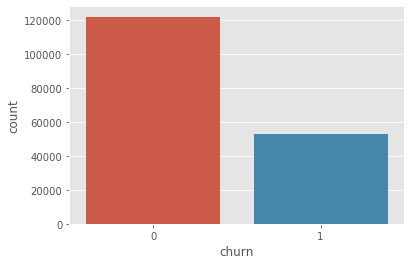

In [19]:
#Visualize the count of customer churn
sns.countplot(df1['churn'])

Target variable distribution is not balanced as there are more non-churned than churned users.

We want to know what percentage of customers are leaving.

In [20]:
#What percentage of customers are leaving ?
retained = df1[df1.churn == 0]
churned = df1[df1.churn == 1]
num_retained = retained.shape[0]
num_churned = churned.shape[0]

#Print the percentage of customers that stayed and left
print( num_retained / (num_retained + num_churned) * 100 , "% of customers still haven an subscription.")

print( num_churned / (num_retained + num_churned) * 100 , "% of customers canceled subscription.")

69.77634322602759 % of customers still haven an subscription.
30.223656773972408 % of customers canceled subscription.


So, about 69.76% of the customers still have an subscription and about 30.24% of the costumers canceled their subscription. This is an important information, because it means that just by always guessing a random customer to still have an subscription from the data set, we have a 69.76% chance of guessing correctly. So, we want the model´s accuracy to classify/predict if a customer will churn to be higher than that percentage.

### Akquisekanal

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

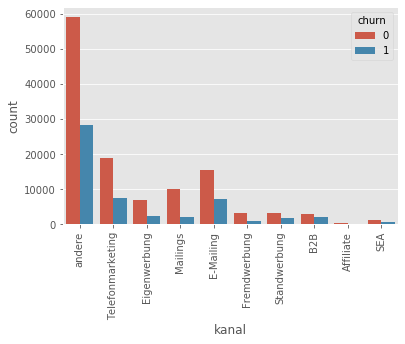

In [21]:
#Visualize the churn count for 'kanal'
sns.countplot(x='kanal', hue='churn', data = df1)
plt.xticks(rotation=90)

We can see from the bar chart that the churn rate is highest for 'Telefonmarketing', 'E-Mailing' and 'andere'.

### Objekt

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

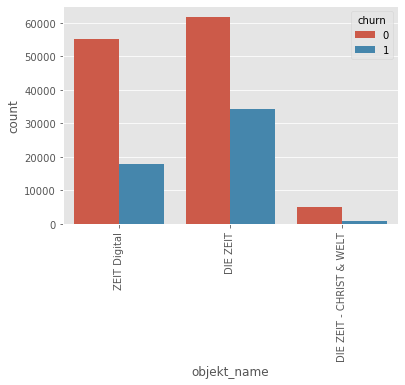

In [22]:
#Visualize the churn count for 'objekt_name'
sns.countplot(x='objekt_name', hue='churn', data = df1)
plt.xticks(rotation=90)

Customers with the 'Die Zeit' subscription have by far the highest churn rate.

### Art des Abos

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

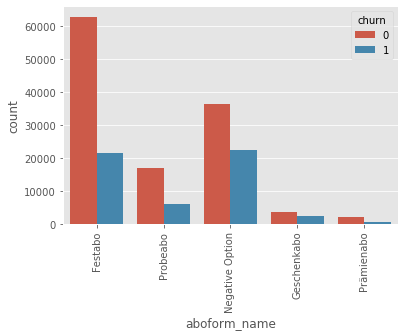

In [23]:
#Visualize the churn count for 'aboform_name'
sns.countplot(x='aboform_name', hue='churn', data = df1)
plt.xticks(rotation=90)

The highest churn rate has the 'Negative Option'. This opens up when you know that these are free subscriptions that have been converted into paid subscriptions.

### Zahlungs Rhythmus Name

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

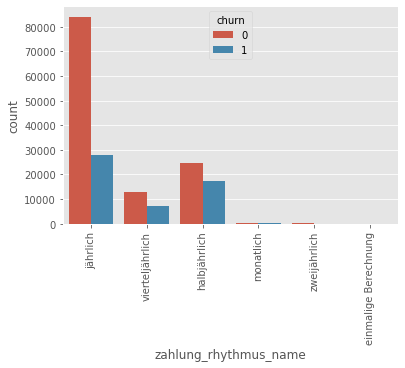

In [24]:
#Visualize the churn count for 'zahlung_rhythmus_name'
sns.countplot(x='zahlung_rhythmus_name', hue='churn', data = df1)
plt.xticks(rotation=90)

### Auftragseingang bis Ende Auftrag

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88]),
 <a list of 89 Text xticklabel objects>)

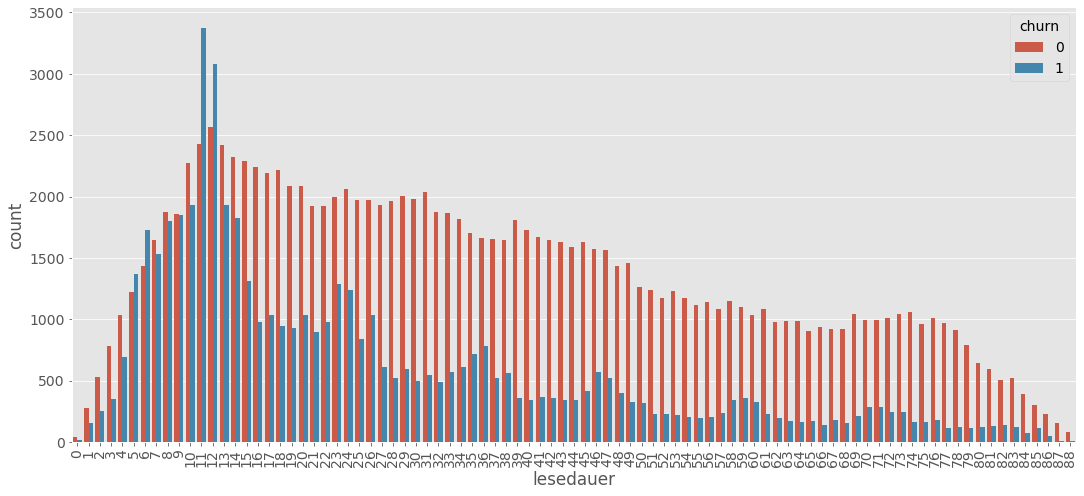

In [25]:
#Visualize the churn count for 'lesedauer'
plt.figure(figsize=(18,8))
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['font.size'] = 14 
sns.countplot(x='lesedauer', hue='churn', data = df1)
plt.xticks(rotation=90)

Here we can guess that the churn rate decreases with the 'lesedauer'.

### Date_x und Lieferbeginn

In [26]:
df1['date_x_month'] = df1['date_x'].str[5:7].astype(int)

In [27]:
df1['liefer_beginn_num'] = df1['liefer_beginn_evt'].str[:4].astype('int') + df1['liefer_beginn_evt'].str[5:7].astype('float')/12 + df1['liefer_beginn_evt'].str[8:10].astype('float')/365

In [28]:
df1.head(1)

Unnamed: 0                        auftrag_new_id liefer_beginn_evt   kanal  \
0           3  25B535B7-D3F9-4804-9FFE-A8C813C8A593        2013-10-17  andere   

    objekt_name aboform_name zahlung_rhythmus_name  lesedauer  rechnungsmonat  \
0  ZEIT Digital      Festabo              jährlich         72               0   

  zahlung_weg_name  ...  clickrate_zeitbrief_1w openrate_zeitbrief_1m  \
0       Bankeinzug  ...                     0.0                  0.67   

  clickrate_zeitbrief_1m openrate_zeitbrief_3m clickrate_zeitbrief_3m  \
0                    0.0                  0.36                    0.0   

   training_set churn               date_x  date_x_month liefer_beginn_num  
0             1     0  2019-10-02 00:00:00            10       2013.879909  

[1 rows x 172 columns]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9adc5722b0>,
      dtype=object)

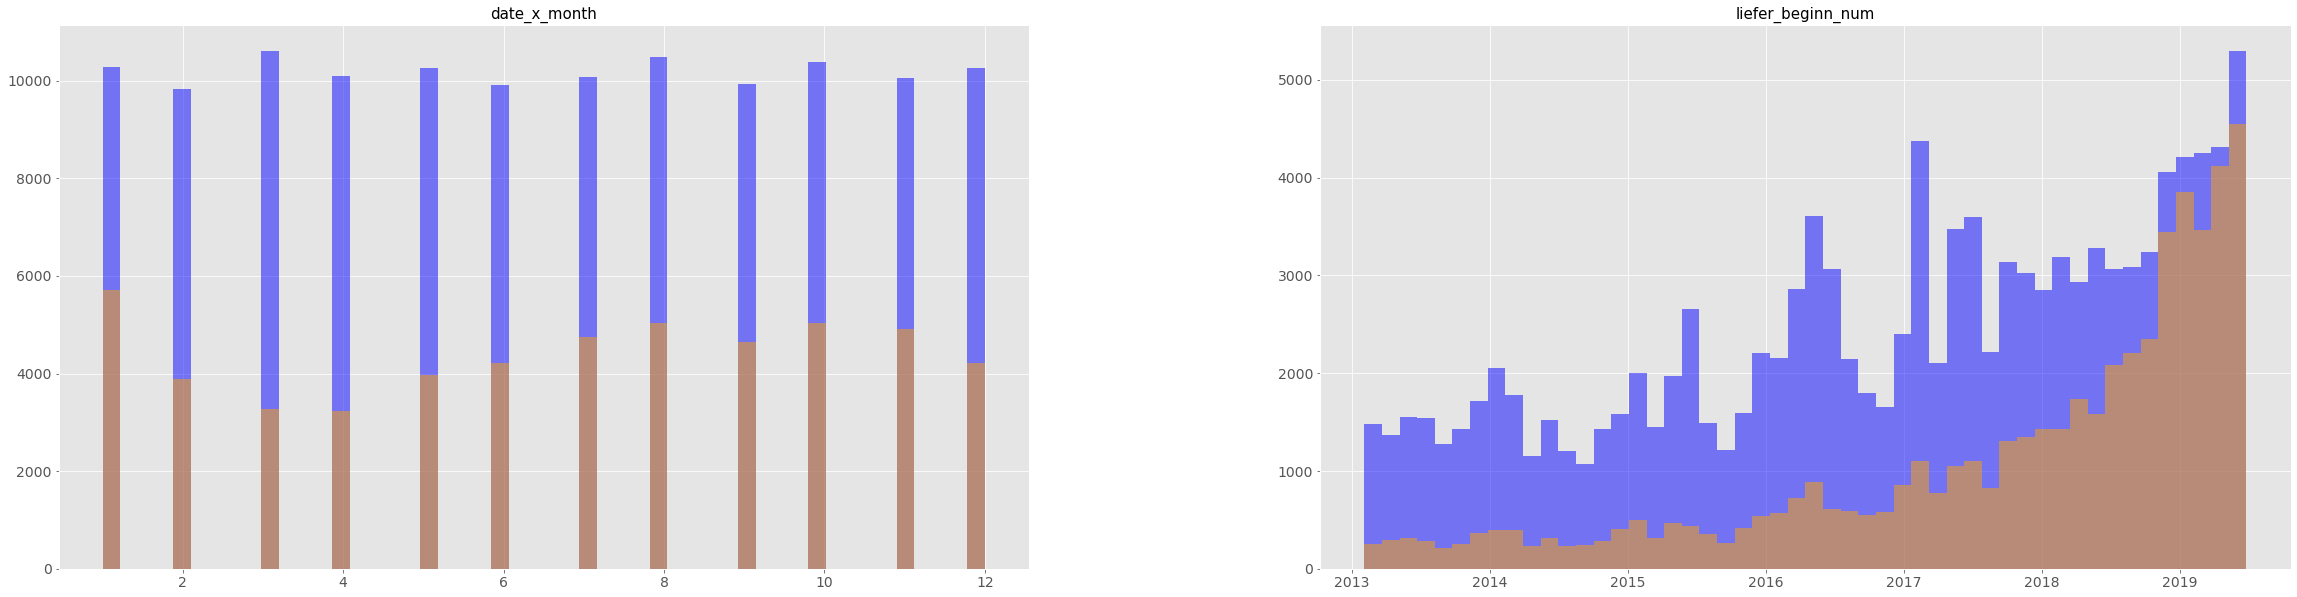

In [29]:
numerical_features = ['date_x_month', 'liefer_beginn_num']
fig, ax = plt.subplots(1, 2, figsize=(40, 10))
df1[df1.churn == 0][numerical_features].hist(bins=50, color="blue",
alpha=0.5, ax=ax)
df1[df1.churn == 1][numerical_features].hist(bins=50, color="orange",
alpha=0.5, ax=ax)



### Handelt es sich um einen Rechnungsmonat

(array([0, 1]), <a list of 2 Text xticklabel objects>)

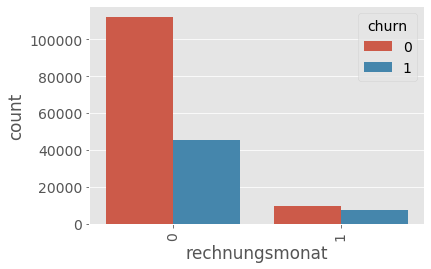

In [30]:
#Visualize the churn count for 'zahlung_rhythmus_name'
sns.countplot(x='rechnungsmonat', hue='churn', data = df1)
plt.xticks(rotation=90)

### Name des Zahlungsweg

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

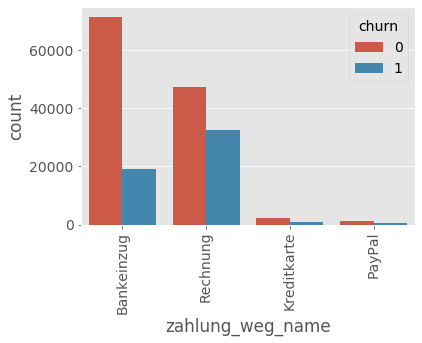

In [31]:
#Visualize the churn count for 'zahlung_rhythmus_name'
sns.countplot(x='zahlung_weg_name', hue='churn', data = df1)
plt.xticks(rotation=90)

### Studentenabo

(array([0, 1]), <a list of 2 Text xticklabel objects>)

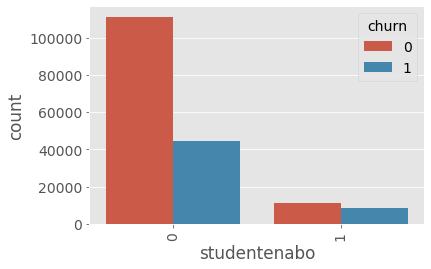

In [32]:
#Visualize the churn count for 'zahlung_rhythmus_name'
sns.countplot(x='studentenabo', hue='churn', data = df1)
plt.xticks(rotation=90)

### Postleitzahl

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

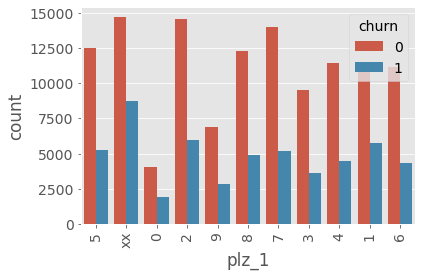

In [33]:
#Visualize the churn count for 'zahlung_rhythmus_name'
sns.countplot(x='plz_1', hue='churn', data = df1)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]),
 <a list of 97 Text xticklabel objects>)

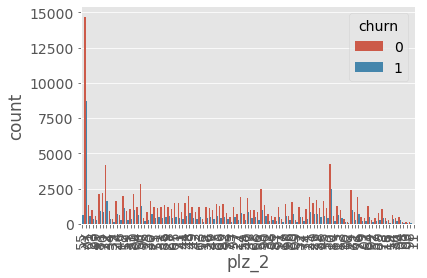

In [34]:
#Visualize the churn count for 'zahlung_rhythmus_name'
sns.countplot(x='plz_2', hue='churn', data = df1)
plt.xticks(rotation=90)

### Metropole/Land ISO Code

(array([0, 1]), <a list of 2 Text xticklabel objects>)

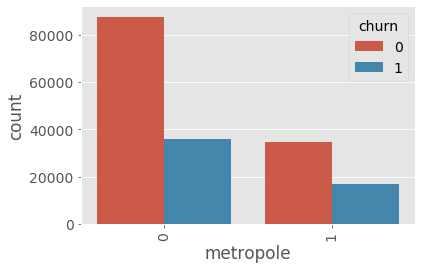

In [35]:
#Visualize the churn count for 'zahlung_rhythmus_name'
sns.countplot(x='metropole', hue='churn', data = df1)
plt.xticks(rotation=90)

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

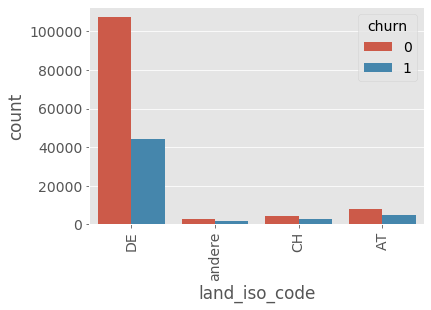

In [36]:
#Visualize the churn count for 'zahlung_rhythmus_name'
sns.countplot(x='land_iso_code', hue='churn', data = df1)
plt.xticks(rotation=90)

### Zeit Shop 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54]),
 <a list of 55 Text xticklabel objects>)

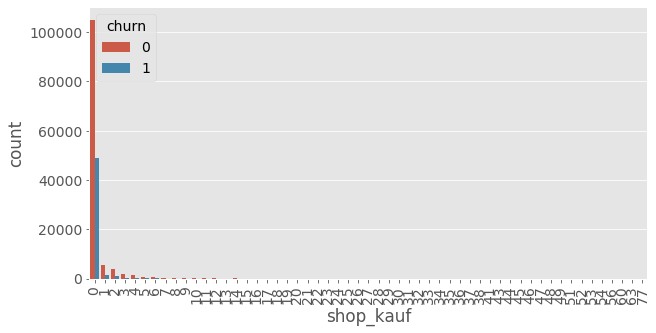

In [37]:
#Visualize the churn count for 'zahlung_rhythmus_name'
plt.figure(figsize=(10,5))
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['font.size'] = 14 
sns.countplot(x='shop_kauf', hue='churn', data = df1)
plt.xticks(rotation=90)

### Unterbrechung des Abonnements

(array([0, 1]), <a list of 2 Text xticklabel objects>)

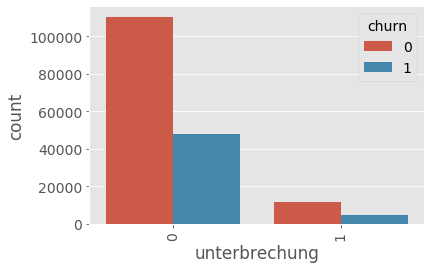

In [38]:
#Visualize the churn count for 'zahlung_rhythmus_name'
sns.countplot(x='unterbrechung', hue='churn', data = df1)
plt.xticks(rotation=90)

### Anrede/Titel

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

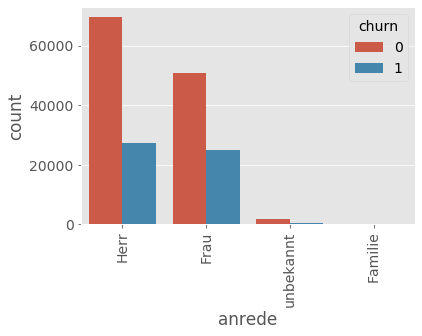

In [39]:
#Visualize the churn count for 'zahlung_rhythmus_name'
sns.countplot(x='anrede', hue='churn', data = df1)
plt.xticks(rotation=90)

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

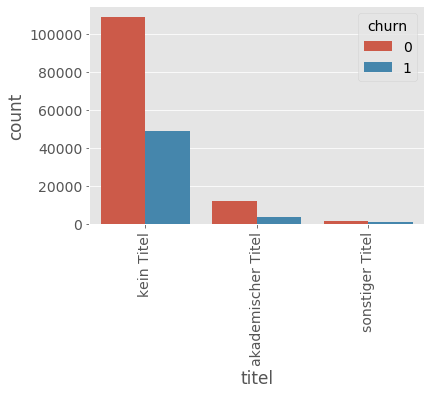

In [40]:
#Visualize the churn count for 'zahlung_rhythmus_name'
sns.countplot(x='titel', hue='churn', data = df1)
plt.xticks(rotation=90)

### Some important features

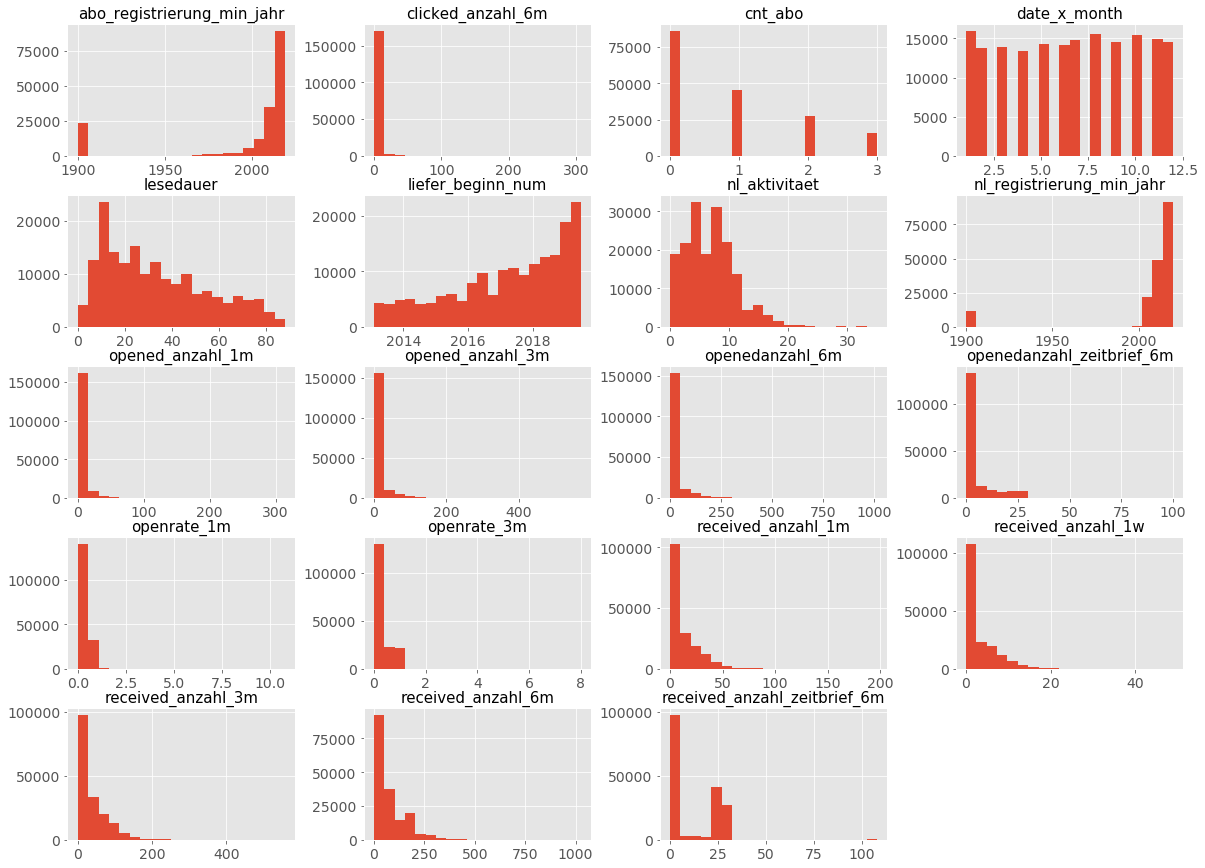

In [80]:
im_F = df1[['liefer_beginn_num', 'lesedauer', 'nl_aktivitaet', 'abo_registrierung_min_jahr',
                   'nl_registrierung_min_jahr', 'received_anzahl_6m', 'date_x_month', 'received_anzahl_3m',
                   'received_anzahl_1m', 'openedanzahl_6m', 'openrate_3m', 'opened_anzahl_3m', 'received_anzahl_1w',
                   'openrate_1m', 'opened_anzahl_1m', 'received_anzahl_zeitbrief_6m', 'openedanzahl_zeitbrief_6m',
                   'clicked_anzahl_6m', 'cnt_abo']].hist(bins=20, figsize=(20, 15), layout=(5, 4))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ac7f98f60>,
      dtype=object)

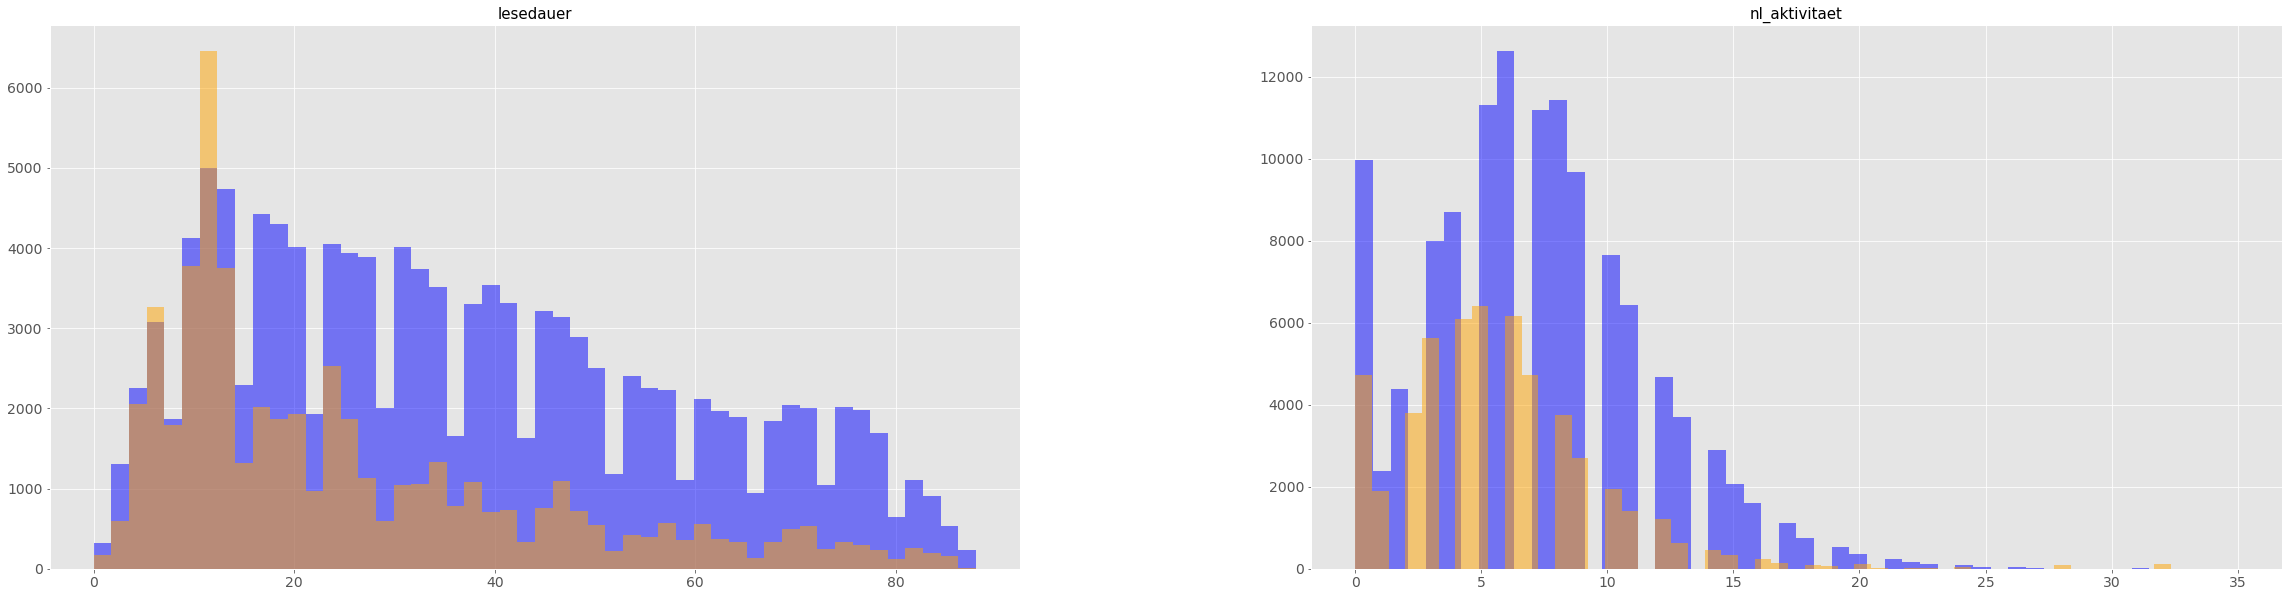

In [41]:
numerical_features = ['lesedauer', 'nl_aktivitaet']
fig, ax = plt.subplots(1, 2, figsize=(40, 10))
df1[df1.churn == 0][numerical_features].hist(bins=50, color="blue",
alpha=0.5, ax=ax)
df1[df1.churn == 1][numerical_features].hist(bins=50, color="orange",
alpha=0.5, ax=ax)

'lesedauer and 'nl_aktivitaet' are very important features to predict the potential churn customers. We can clearly see from the graphs that the churn rate shrinks with increasing 'lesedauer' and higher activity in the newsletter 'nl_aktivitaet'.

## Correlation Matrix

### Filter Method

The filtering here is done using correlation matrix and it is most commonly done using Pearson correlation.

In [42]:
#First we create a new DataFrame with only numerical features
numerics = ['int64', 'float64']

num_df = df1.select_dtypes(include=numerics)

In [43]:
num_df.shape

(175045, 155)

In [44]:
num_df.head(1)

Unnamed: 0  lesedauer  rechnungsmonat  studentenabo  metropole  shop_kauf  \
0           3         72               0             0          0          0   

   unterbrechung  avg_churn  email_am_kunden  zon_che_opt_in  ...  \
0              0   0.172959              1.0               0  ...   

   openrate_zeitbrief_1w  clickrate_zeitbrief_1w  openrate_zeitbrief_1m  \
0                    1.0                     0.0                   0.67   

   clickrate_zeitbrief_1m  openrate_zeitbrief_3m  clickrate_zeitbrief_3m  \
0                     0.0                   0.36                     0.0   

   training_set  churn  date_x_month  liefer_beginn_num  
0             1      0            10        2013.879909  

[1 rows x 155 columns]

#### First ten features 0-9

We look always at ten features plus the label 'churn' at the same time.

In [45]:
num_df1 = num_df.iloc[: ,[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 152]].copy()

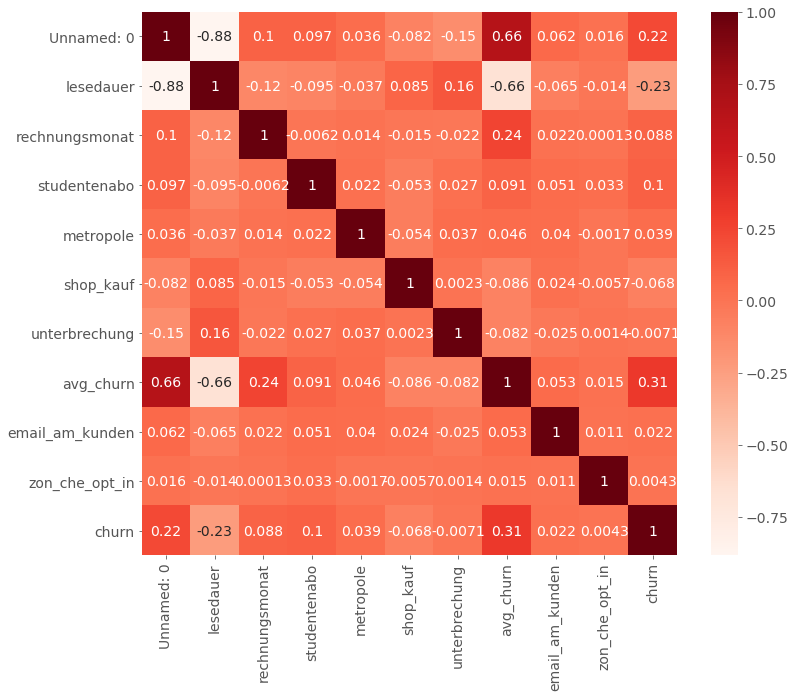

In [46]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df1.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 10-19 

In [47]:
num_df2 = num_df.iloc[: ,[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 152]].copy()

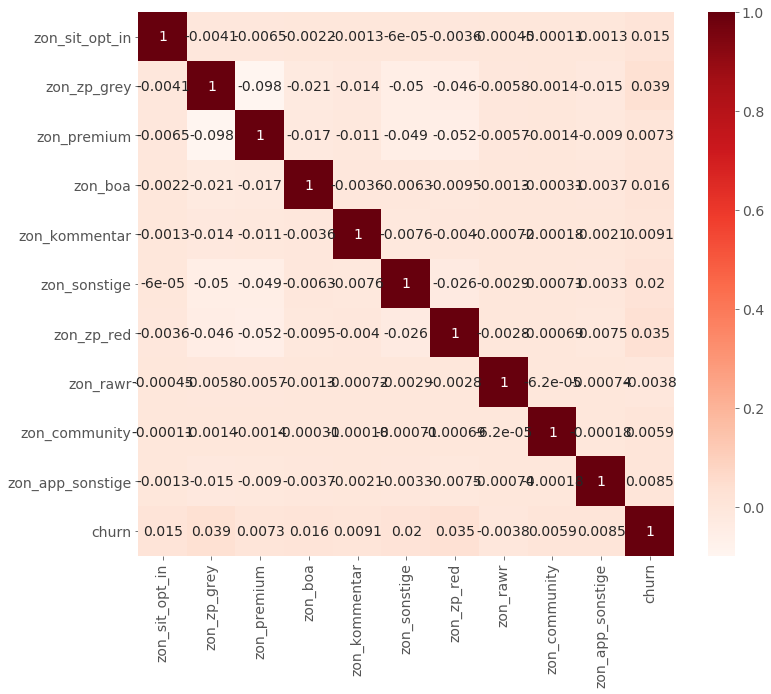

In [48]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df2.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 20-29

In [49]:
num_df3 = num_df.iloc[: ,[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 152]].copy()

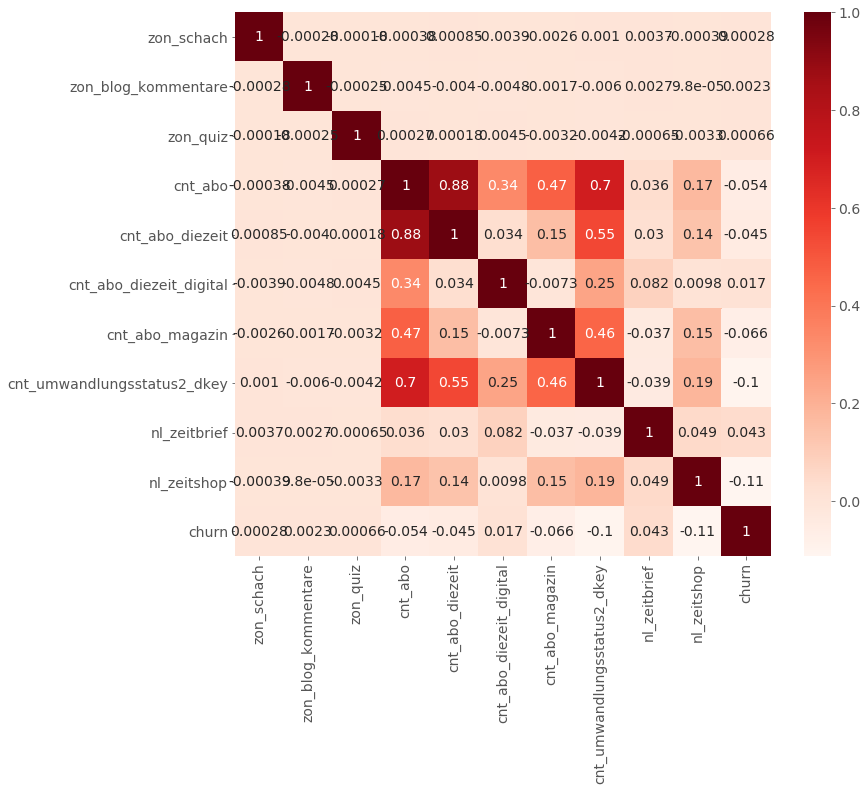

In [50]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df3.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 30-39

In [51]:
num_df4 = num_df.iloc[: ,[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 152]].copy()

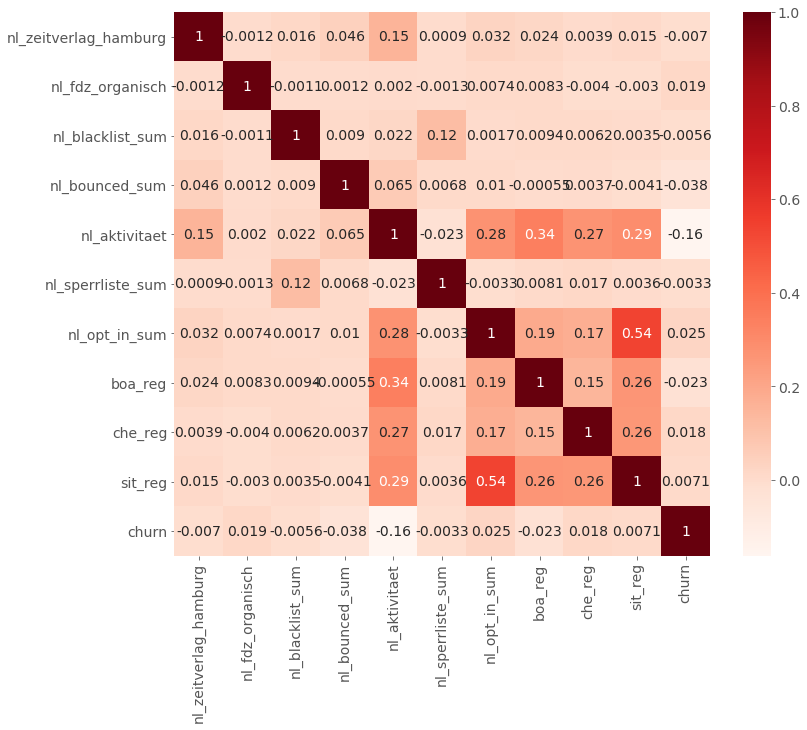

In [52]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df4.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 40-49

In [53]:
num_df5 = num_df.iloc[: ,[40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 152]].copy()

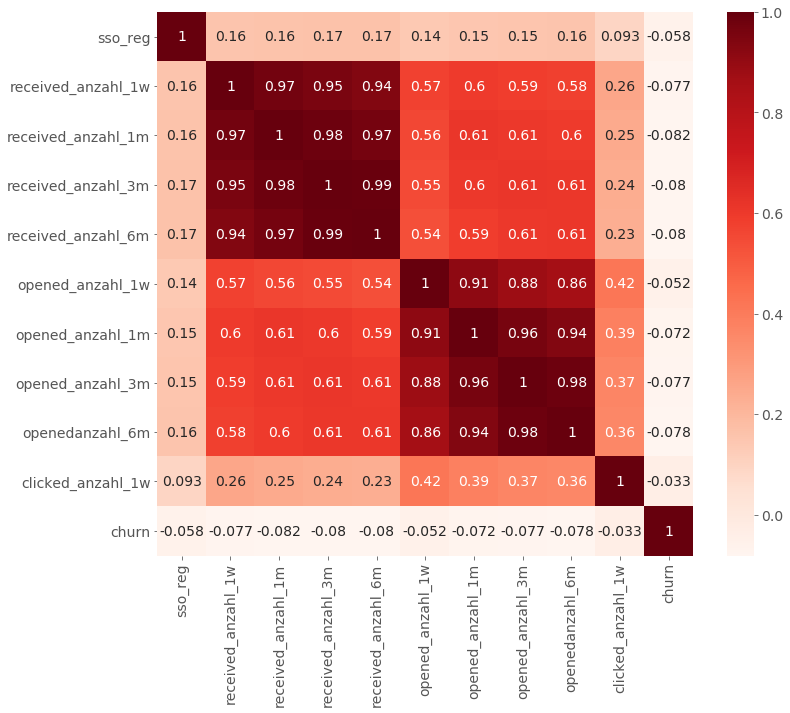

In [54]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df5.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 50-59

In [55]:
num_df6 = num_df.iloc[: ,[50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 152]].copy()

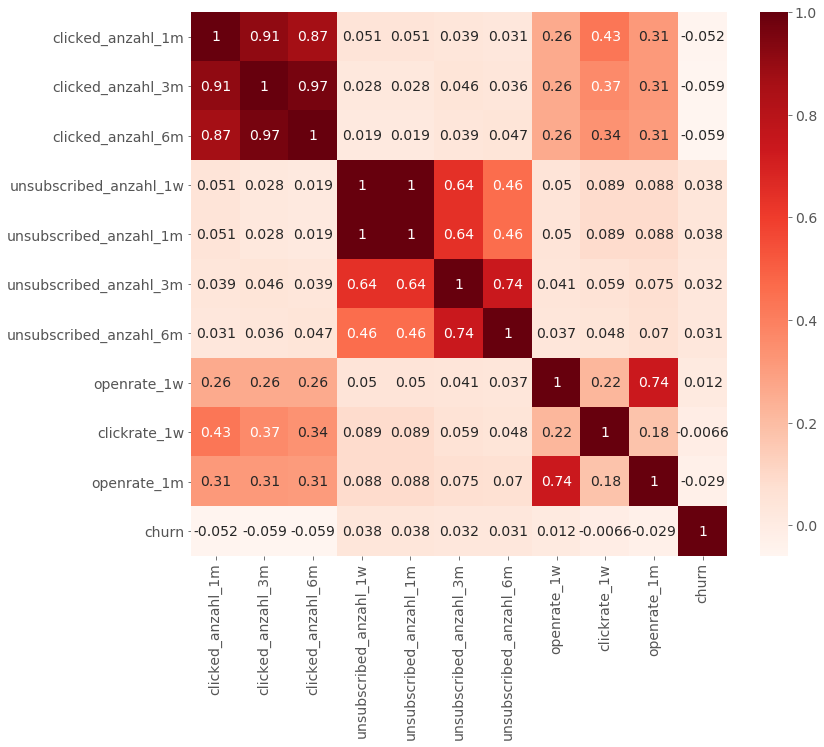

In [56]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df6.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 60-69

In [57]:
num_df7 = num_df.iloc[: ,[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 152]].copy()

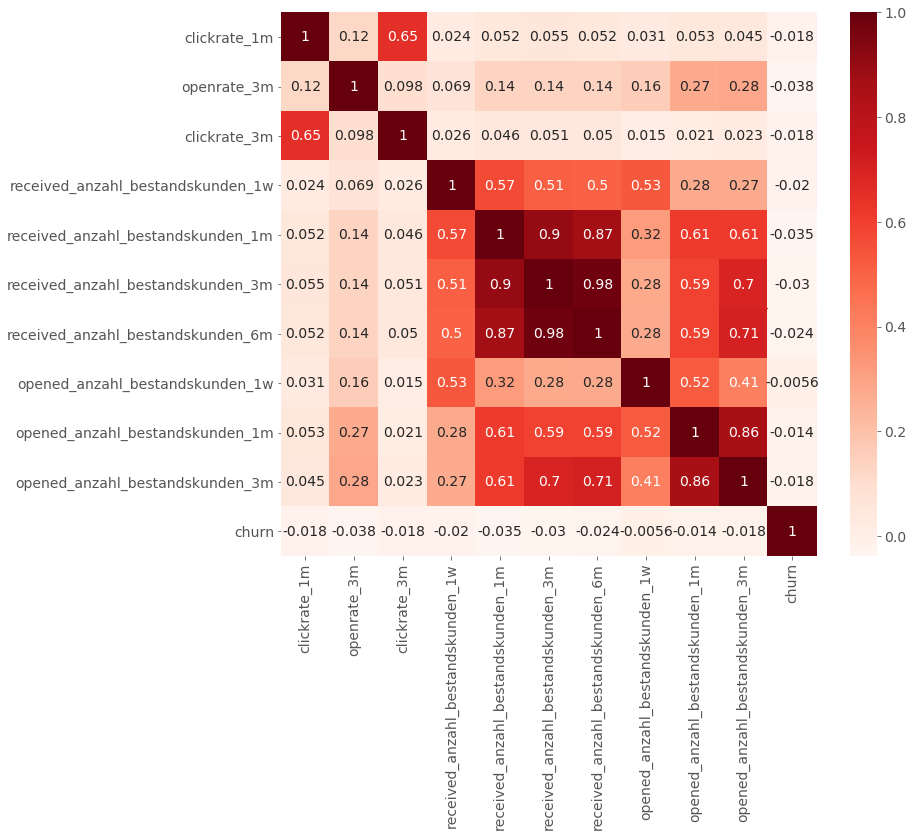

In [58]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df7.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 70-79

In [59]:
num_df8 = num_df.iloc[: ,[70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 152]].copy()

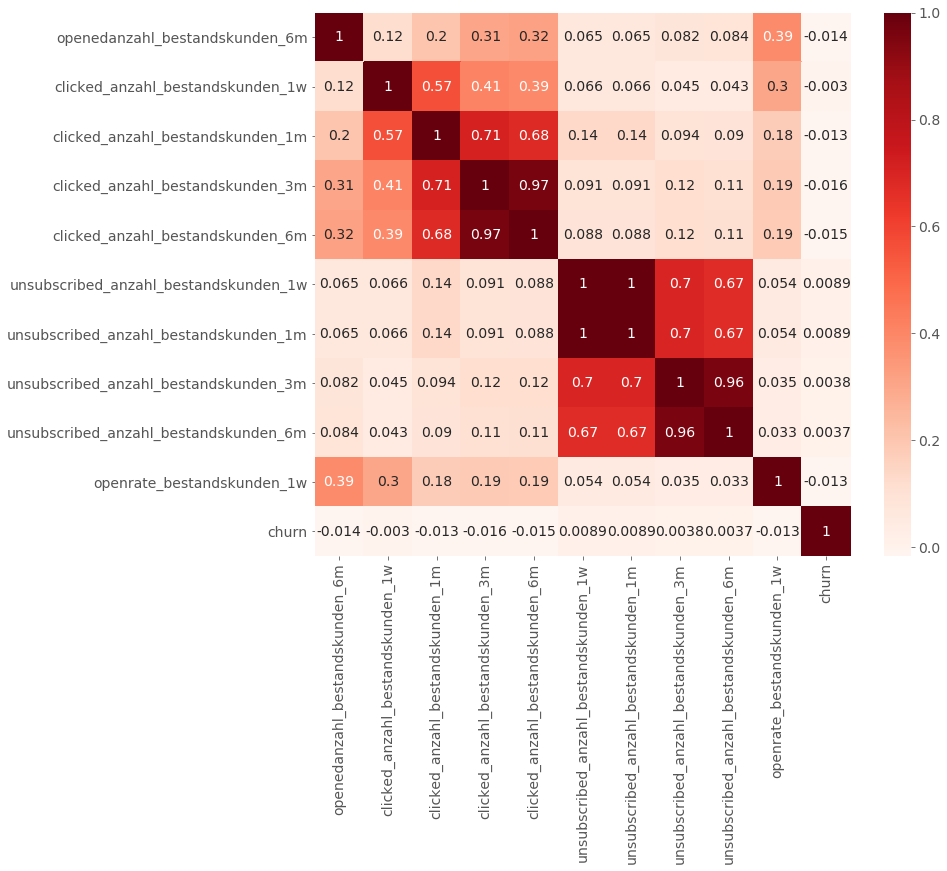

In [60]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df8.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 80-89

In [61]:
num_df9 = num_df.iloc[: ,[80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 152]].copy()

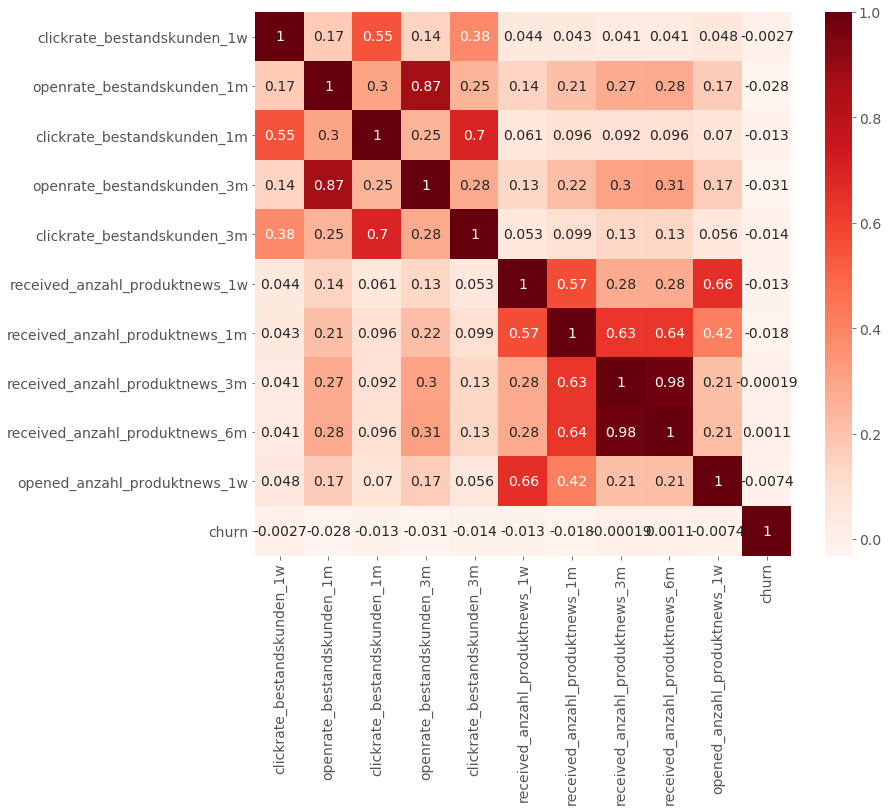

In [62]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df9.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 90-99

In [63]:
num_df10 = num_df.iloc[: ,[90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 152]].copy()

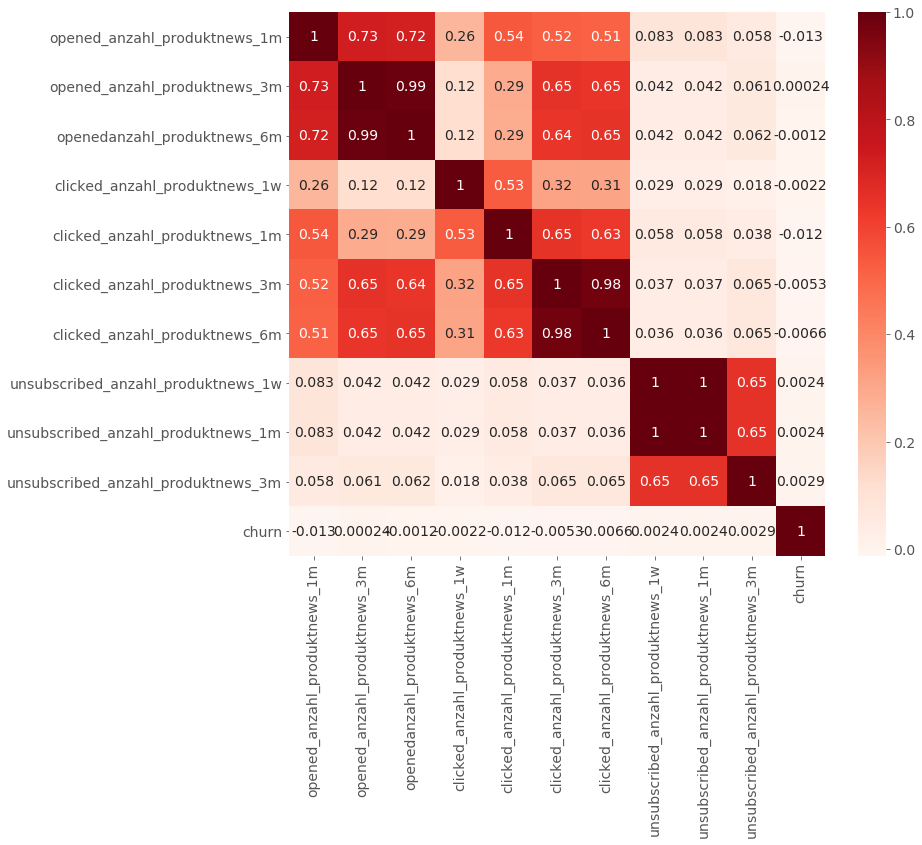

In [64]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df10.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 100-109

In [65]:
num_df11 = num_df.iloc[: ,[100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 152]].copy()

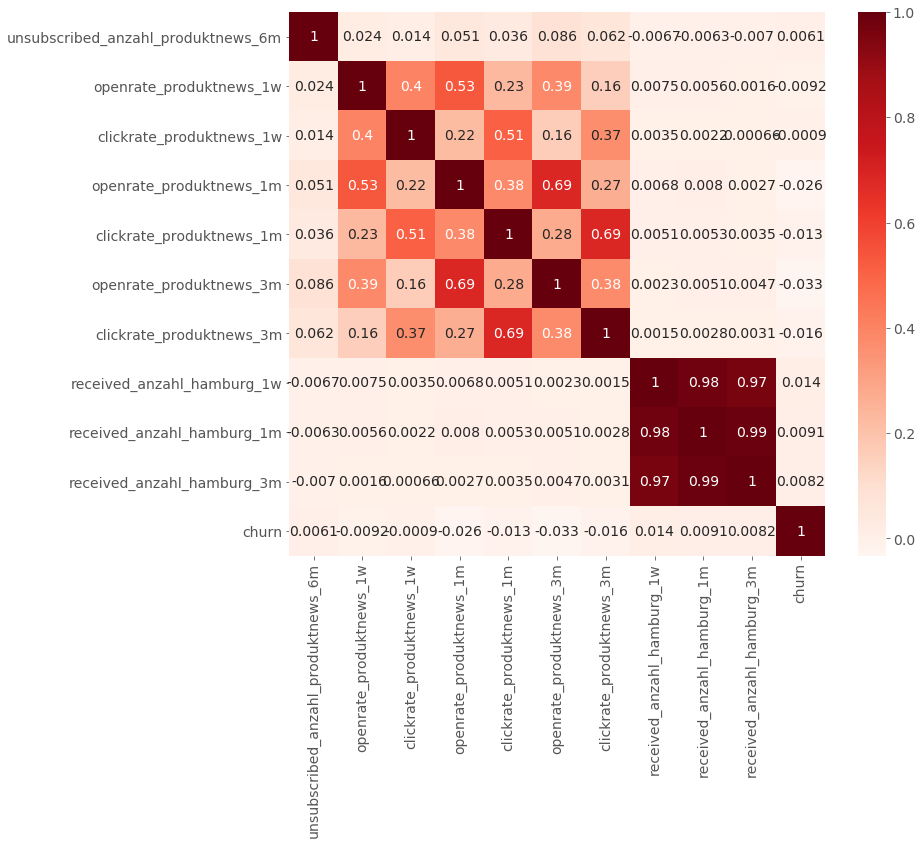

In [66]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df11.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 110-119

In [67]:
num_df12 = num_df.iloc[: ,[110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 152]].copy()

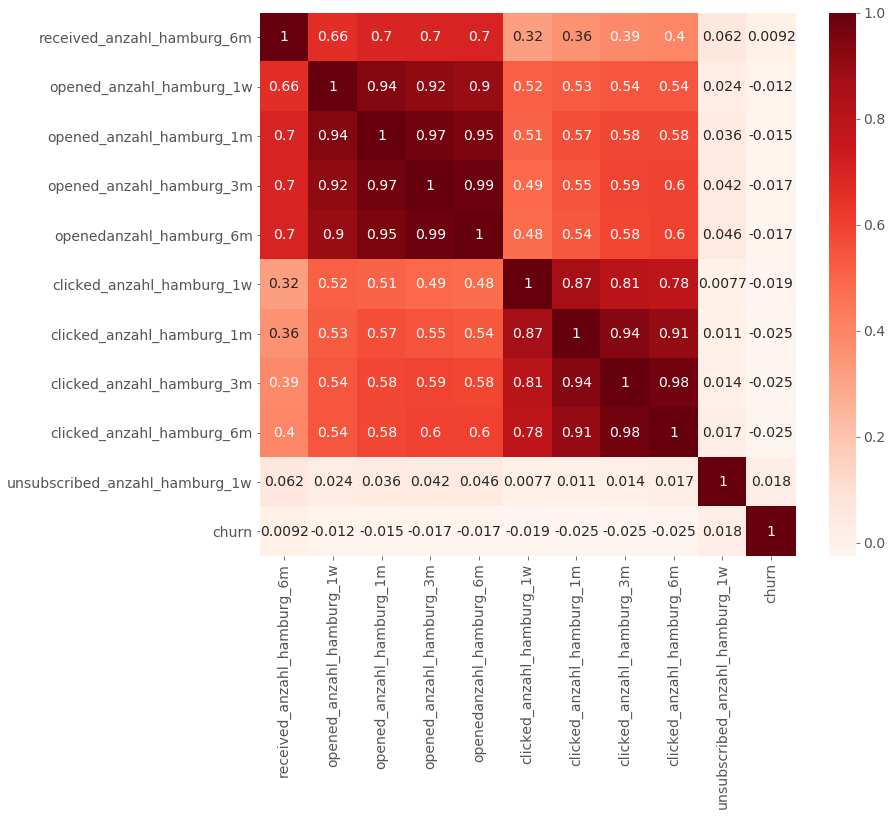

In [68]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df12.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 120-129

In [69]:
num_df13 = num_df.iloc[: ,[120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 152]].copy()

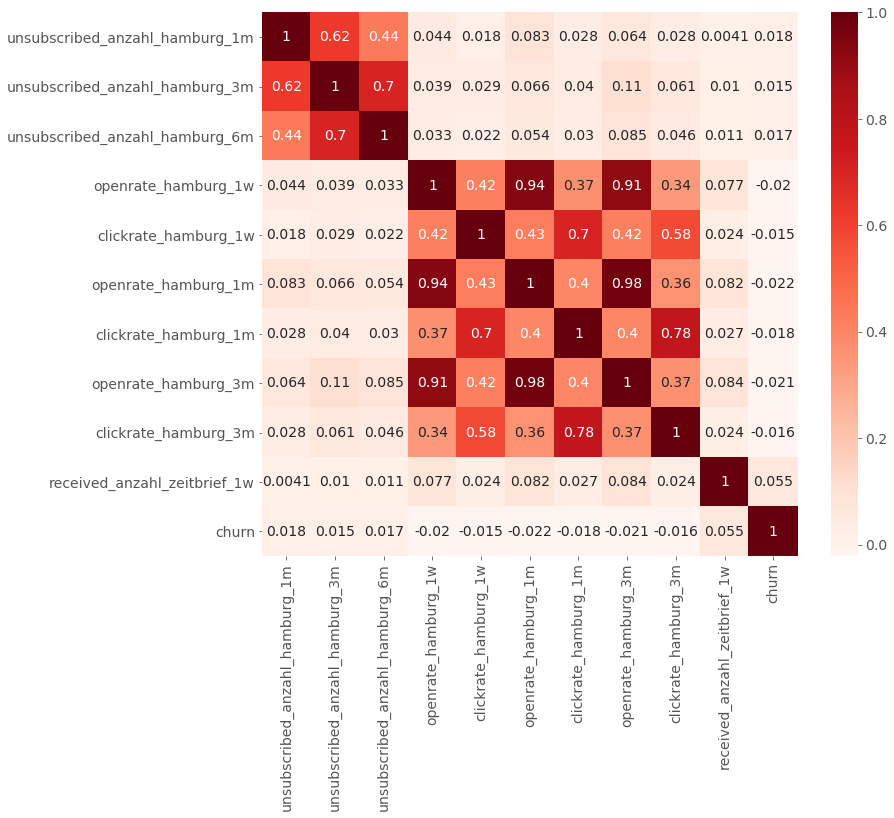

In [70]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df13.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 130-139

In [71]:
num_df14 = num_df.iloc[: ,[130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 152]].copy()

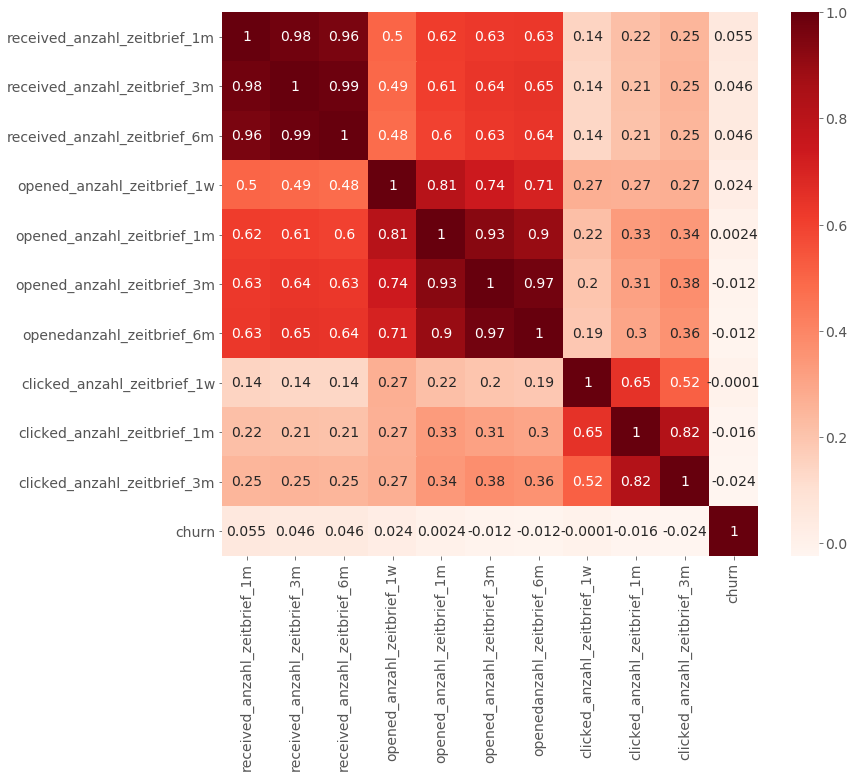

In [72]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df14.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

#### 140-154

In [73]:
num_df15 = num_df.iloc[: ,[140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 152, 153, 154]].copy()

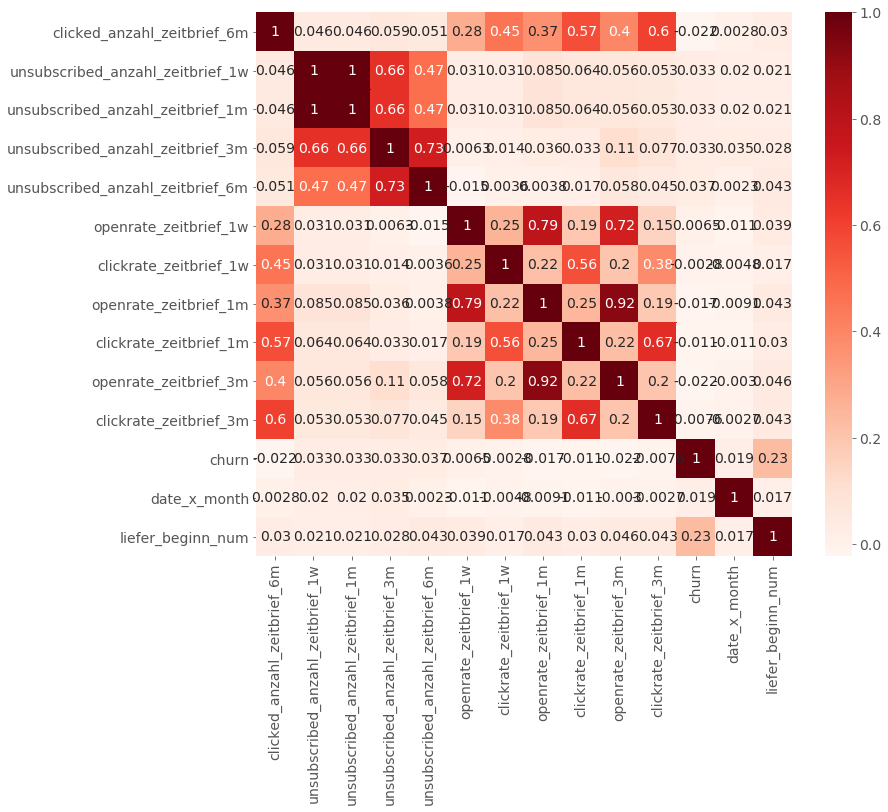

In [74]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = num_df15.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

As we can see no numerical feature is highly correlated with the output variable 'churn'. The highest correlation is between 'churn' and 'avg_churn', but we have to drop 'avg_churn because of data leakage.  Because the 'avg_churn' feature was created with information from the 'churn' variable. The highest correlations to the label 'churn' show the variables 'liefer_beginn_num', nl_aktivitaet ', nl_zeitshop', 'lesedauer', 'studentenabo' and 'cnt_umwandlungsstatus2_dkey'. What we can still see is that there are very high correlations between many other features.

## Feature Engineering

We take the year from 'abo_registrierung_min' and 'nl_registrierung_min' save them in two new variables, because the information is in the year.

In [75]:
df1['abo_registrierung_min_jahr'] = df1['abo_registrierung_min'].str[:4].astype('int')
df1['nl_registrierung_min_jahr'] = df1['nl_registrierung_min'].str[:4].astype('int')

In [76]:
df1.drop(['abo_registrierung_min', 'nl_registrierung_min'],axis=1,inplace=True)

In [77]:
df1.shape

(175045, 172)

### Dummie Variables

We make dummies out of our categorical variables to look for top features using Random Forest and Random Forest needs numerical features.

In [78]:
df1.select_dtypes(exclude=['int', 'float']).columns

Index(['auftrag_new_id', 'liefer_beginn_evt', 'kanal', 'objekt_name',
       'aboform_name', 'zahlung_rhythmus_name', 'zahlung_weg_name', 'plz_1',
       'plz_2', 'plz_3', 'ort', 'land_iso_code', 'anrede', 'titel', 'date_x'],
      dtype='object')

In [79]:
df1.drop(['date_x', 'ort', 'auftrag_new_id', 'liefer_beginn_evt'],axis=1,inplace=True)

We drop 'date_x' and 'liefer_beginn_evt' because thats only dates and we already made numerical features out of the information we think is necessary. 'auftrag_new_id' is for every data point special, so there is no information for our model. 

In [81]:
df1 = pd.get_dummies(df1, columns = ['kanal', 'objekt_name',
       'aboform_name', 'zahlung_rhythmus_name', 'zahlung_weg_name', 'plz_1',
       'plz_2', 'plz_3', 'land_iso_code', 'anrede', 'titel'], drop_first = True)


In [82]:
df1.select_dtypes(exclude=['int', 'float']).columns

Index(['kanal_B2B', 'kanal_E-Mailing', 'kanal_Eigenwerbung',
       'kanal_Fremdwerbung', 'kanal_Mailings', 'kanal_SEA',
       'kanal_Standwerbung', 'kanal_Telefonmarketing', 'kanal_andere',
       'objekt_name_DIE ZEIT - CHRIST & WELT',
       ...
       'plz_3_999', 'plz_3_xx', 'land_iso_code_CH', 'land_iso_code_DE',
       'land_iso_code_andere', 'anrede_Frau', 'anrede_Herr',
       'anrede_unbekannt', 'titel_kein Titel', 'titel_sonstiger Titel'],
      dtype='object', length=833)

In [83]:
df1.shape

(175045, 990)

In [84]:
X, y = df1.drop('churn',axis=1), df1[['churn']]

### Feature Selection

/Users/sebastianfuhrer/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Text(0.5, 1.0, 'Top Features derived by Random Forest')

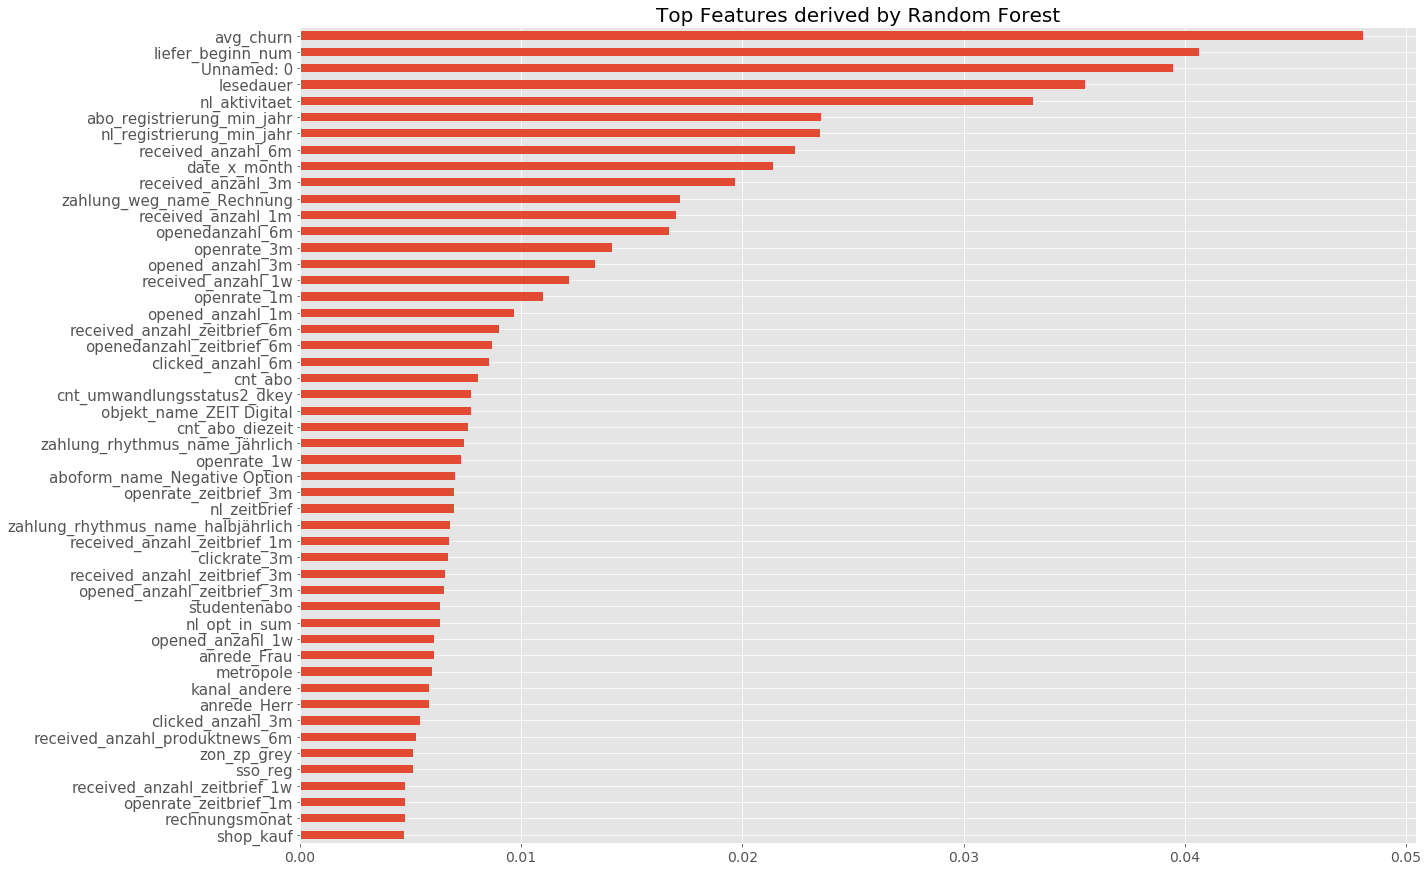

In [85]:
## To look for top features using Random Forest
# Create decision tree classifer object
rfc = RandomForestClassifier(random_state=0, n_estimators=100)

# Train model, note that NO scaling is required
model = rfc.fit(X, y)

# Plot the top features based on its importance
(pd.Series(model.feature_importances_, index=X.columns)
   .nlargest(50)   # can adjust based on how many top features you want
   .plot(kind='barh', figsize=[20,15])
    .invert_yaxis()) # Ensures that the feature with the most importance is on top, in descending order

plt.yticks(size=15)
plt.title('Top Features derived by Random Forest', size=20)

The highest correlation is between 'churn' and 'avg_churn', but we have to drop 'avg_churn because of data leakage. Because the 'avg_churn' feature was created with information from the 'churn' variable.

We drop 'Unnamed: 0' because its only an index column and we also drop the 'training_set' column because there are only ones in this column without explanatory content.

In [86]:
# Dropping the unnecessary columns 
df1.drop(['Unnamed: 0', 'training_set'],axis=1,inplace=True)

### Multicollinearity between the top features

In [87]:
top_df = df1[['liefer_beginn_num', 'lesedauer', 'nl_aktivitaet', 'abo_registrierung_min_jahr',
                   'nl_registrierung_min_jahr', 'received_anzahl_6m', 'date_x_month', 'received_anzahl_3m',
                   'received_anzahl_1m', 'openedanzahl_6m', 'openrate_3m', 'opened_anzahl_3m', 'received_anzahl_1w',
                   'openrate_1m', 'opened_anzahl_1m', 'received_anzahl_zeitbrief_6m', 'openedanzahl_zeitbrief_6m',
                   'clicked_anzahl_6m', 'cnt_abo', 'zahlung_weg_name_Rechnung']].copy()

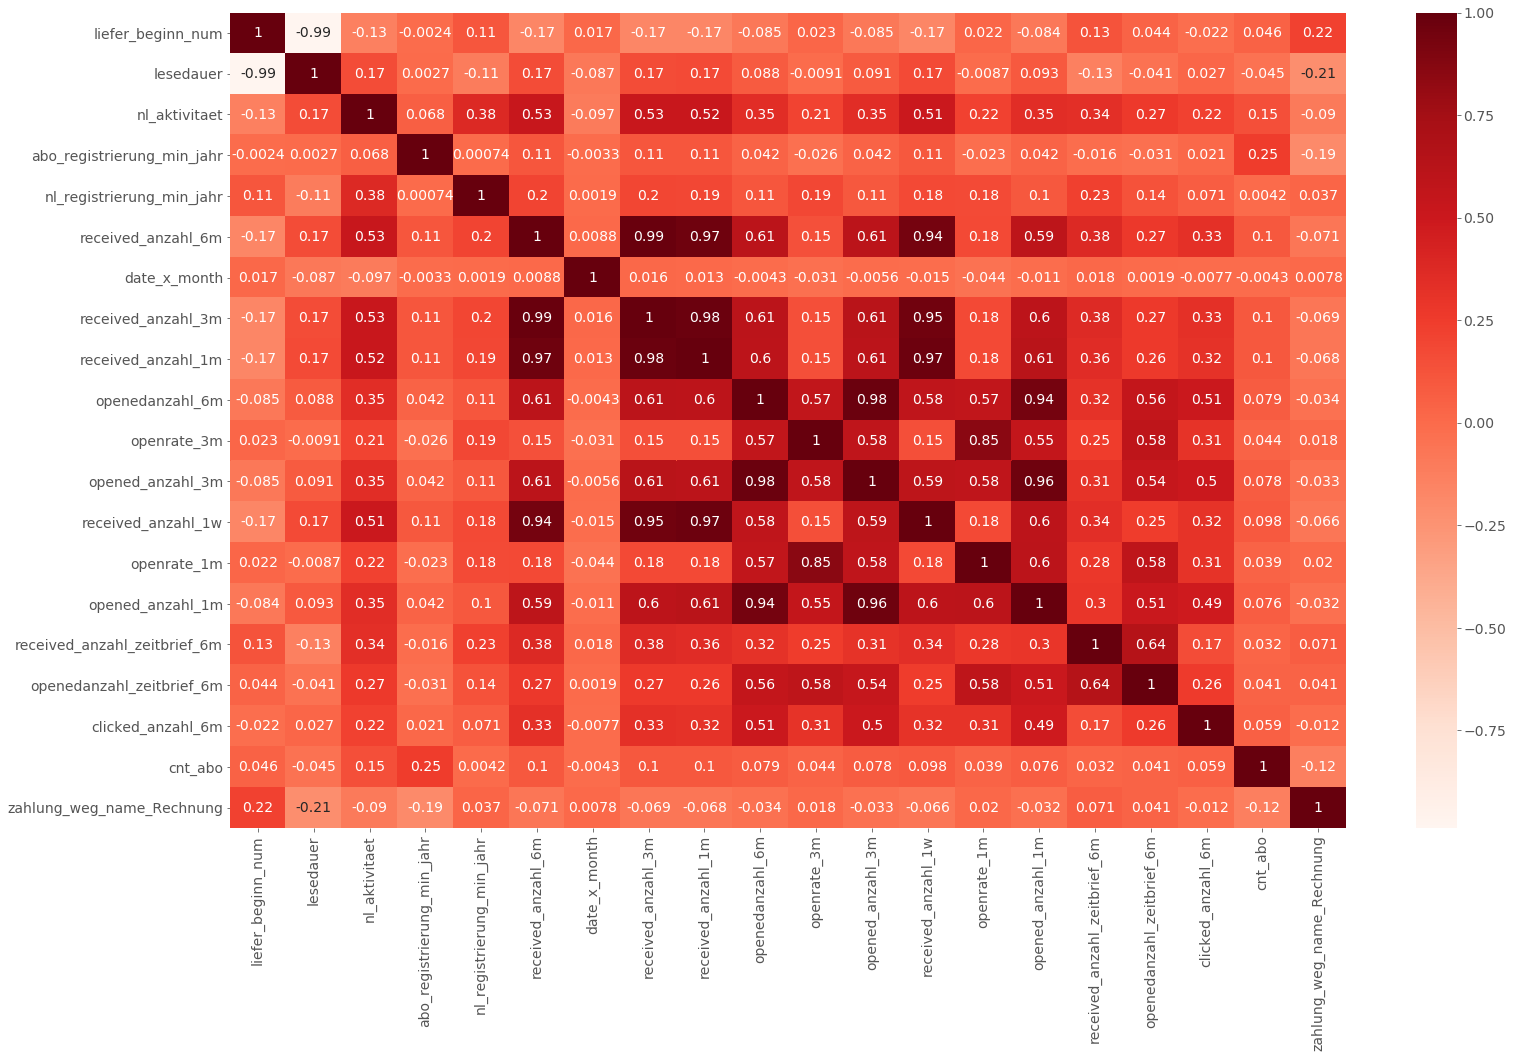

In [88]:
#Using Pearson Correlation
plt.figure(figsize=(25,15))
cor = top_df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

'lesedauer', received_anzahl_3m, received_anzahl_1m, received_anzahl_1w, opened_anzahl_3m, opened_anzahl_1m and openrate_1m are highly correlated with each other, so we drop them out of our top feature list and looking for the next best features.

In [89]:
top_df1 = df1[['cnt_umwandlungsstatus2_dkey', 'objekt_name_ZEIT Digital', 'cnt_abo_diezeit', 
               'zahlung_rhythmus_name_jährlich', 'openrate_1w', 'aboform_name_Negative Option', 
               'openrate_zeitbrief_3m','liefer_beginn_num', 'nl_aktivitaet', 'abo_registrierung_min_jahr',
               'nl_registrierung_min_jahr', 'received_anzahl_6m', 'date_x_month', 'openedanzahl_6m', 
               'openrate_3m', 'received_anzahl_zeitbrief_6m', 'openedanzahl_zeitbrief_6m',
               'clicked_anzahl_6m', 'cnt_abo', 'zahlung_weg_name_Rechnung']].copy()

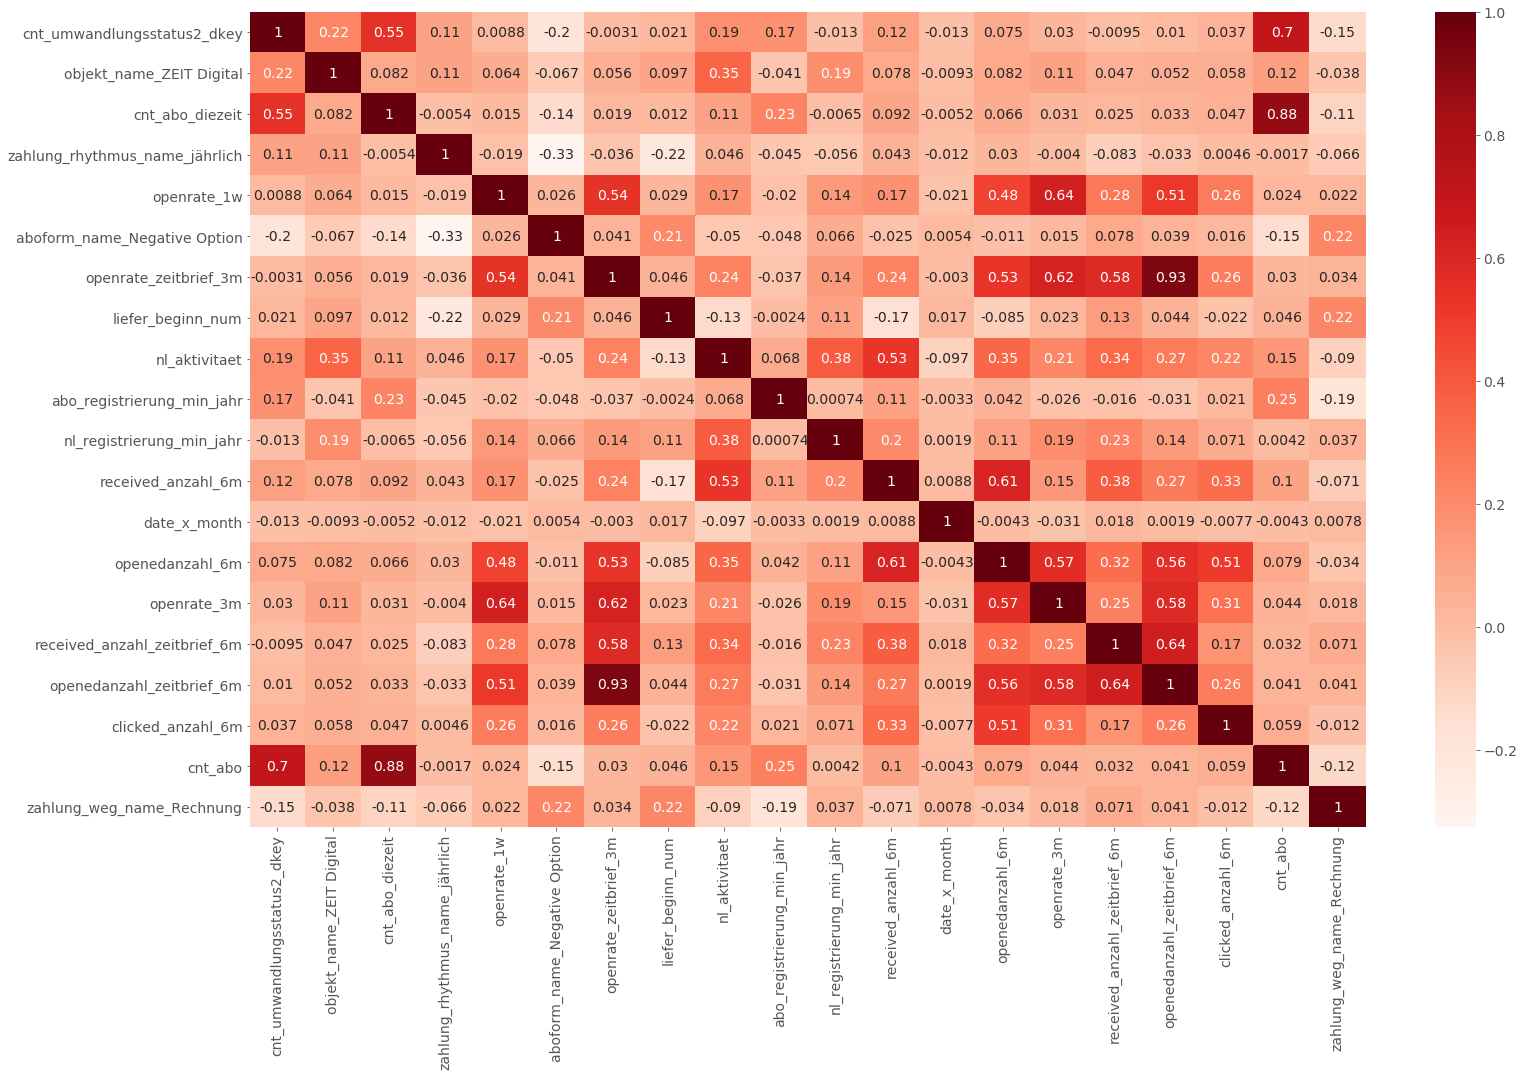

In [90]:
#Using Pearson Correlation
plt.figure(figsize=(25,15))
cor = top_df1.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

'openedanzahl_zeitbrief_3m' and cnt_abo_diezeit are highly correlated with one feature in our list, so we drop them out of our top feature list.

In [91]:
top_df2 = df1[['zahlung_weg_name_Rechnung', 'zahlung_rhythmus_name_jährlich', 
               'aboform_name_Negative Option', 'objekt_name_ZEIT Digital', 'liefer_beginn_num', 
               'nl_aktivitaet', 'abo_registrierung_min_jahr', 'nl_registrierung_min_jahr', 
               'received_anzahl_6m', 'date_x_month', 'openedanzahl_6m', 'openrate_3m', 
               'received_anzahl_zeitbrief_6m', 'openedanzahl_zeitbrief_6m', 'clicked_anzahl_6m', 
               'cnt_abo', 'cnt_umwandlungsstatus2_dkey', 'openrate_1w', 'nl_zeitbrief', 
               'clickrate_3m']].copy()

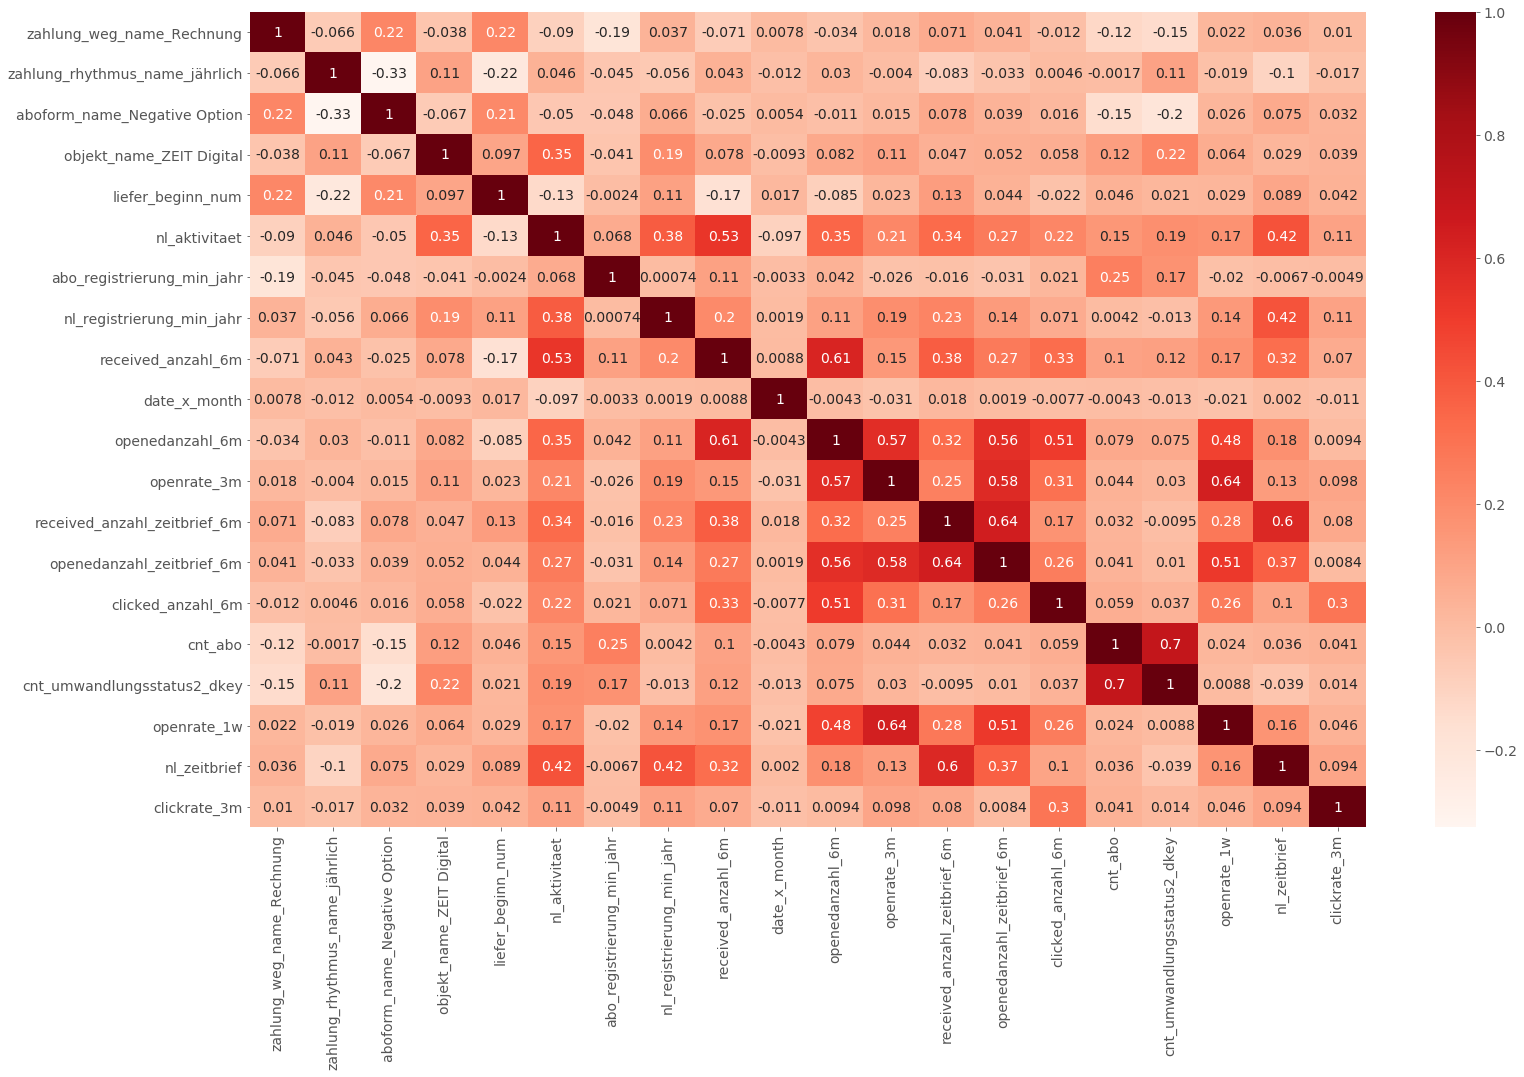

In [92]:
#Using Pearson Correlation
plt.figure(figsize=(25,15))
cor = top_df2.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Here we got our twenty top features.

## Building a Preprocessing Pipeline

In [93]:
# Creating list for categorical predictors/features 
cat_features = list(['zahlung_weg_name_Rechnung', 'zahlung_rhythmus_name_jährlich',
                     'aboform_name_Negative Option', 'objekt_name_ZEIT Digital', 'nl_zeitbrief'])
cat_features

['zahlung_weg_name_Rechnung',
 'zahlung_rhythmus_name_jährlich',
 'aboform_name_Negative Option',
 'objekt_name_ZEIT Digital',
 'nl_zeitbrief']

In [94]:
# Creating list for numerical predictors/features
num_features = list(['liefer_beginn_num', 'nl_aktivitaet', 'abo_registrierung_min_jahr',
                   'nl_registrierung_min_jahr', 'received_anzahl_6m', 'date_x_month', 'openedanzahl_6m', 
                   'openrate_3m', 'received_anzahl_zeitbrief_6m', 'openedanzahl_zeitbrief_6m',
                   'clicked_anzahl_6m', 'cnt_abo', 'cnt_umwandlungsstatus2_dkey', 'openrate_1w', 'clickrate_3m'])
num_features

['liefer_beginn_num',
 'nl_aktivitaet',
 'abo_registrierung_min_jahr',
 'nl_registrierung_min_jahr',
 'received_anzahl_6m',
 'date_x_month',
 'openedanzahl_6m',
 'openrate_3m',
 'received_anzahl_zeitbrief_6m',
 'openedanzahl_zeitbrief_6m',
 'clicked_anzahl_6m',
 'cnt_abo',
 'cnt_umwandlungsstatus2_dkey',
 'openrate_1w',
 'clickrate_3m']

In [95]:
# Define predictors and target variable
X = df1[['zahlung_weg_name_Rechnung', 'zahlung_rhythmus_name_jährlich', 
         'aboform_name_Negative Option', 'objekt_name_ZEIT Digital', 'nl_zeitbrief', 'liefer_beginn_num', 
         'nl_aktivitaet', 'abo_registrierung_min_jahr', 'nl_registrierung_min_jahr', 'received_anzahl_6m', 
         'date_x_month', 'openedanzahl_6m', 'openrate_3m', 'received_anzahl_zeitbrief_6m', 
         'openedanzahl_zeitbrief_6m', 'clicked_anzahl_6m', 'cnt_abo', 'cnt_umwandlungsstatus2_dkey', 
         'openrate_1w', 'clickrate_3m']].copy()

y = df1['churn']
print(X.shape)
print(y.shape)

(175045, 20)
(175045,)


### Train Test Split

In [96]:
# Split into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

## Unbalanced data set

In [97]:
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)
X.head()

zahlung_weg_name_Rechnung  zahlung_rhythmus_name_jährlich  \
161                             0                               1   
14415                           0                               1   
157792                          0                               0   
132312                          1                               0   
147402                          1                               0   

        aboform_name_Negative Option  objekt_name_ZEIT Digital  nl_zeitbrief  \
161                                0                         0             2   
14415                              0                         1             0   
157792                             1                         0             2   
132312                             1                         0             0   
147402                             0                         1             0   

        liefer_beginn_num  nl_aktivitaet  abo_registrierung_min_jahr  \
161           2014.877169              8                        2014   
14415         2013.323973              3                        2013   
157792        2018.729680              5                        2018   
132312        2019.326712              5                        2019   
147402        2019.202283              3                        1900   

        nl_registrierung_min_jahr  received_anzahl_6m  ...  openedanzahl_6m  \
161                          2014                 176  ...              167   
14415                        2013                   3  ...                0   
157792                       2018                  33  ...                1   
132312                       2017                 303  ...              155   
147402                       2019                  30  ...                2   

        openrate_3m  received_anzahl_zeitbrief_6m  openedanzahl_zeitbrief_6m  \
161            0.98                            26                         24   
14415          0.00                             0                          0   
157792         0.00                             0                          0   
132312         0.54                             0                          0   
147402         0.00                             0                          0   

        clicked_anzahl_6m  cnt_abo  cnt_umwandlungsstatus2_dkey  openrate_1w  \
161                     1        0                            0         1.14   
14415                   0        0                            0         0.00   
157792                  0        0                            0         0.00   
132312                  0        0                            0         0.43   
147402                  0        0                            0         0.00   

        clickrate_3m  churn  
161             0.01      0  
14415           0.00      0  
157792          0.00      0  
132312          0.00      1  
147402          0.00      0  

[5 rows x 21 columns]

In [98]:
from sklearn.utils import resample
# separate minority and majority classes
still_sub = X[X.churn==0]
no_sub = X[X.churn==1]

# upsample minority
sub_upsampled = resample(no_sub,
                          replace=True, # sample with replacement
                          n_samples=len(still_sub), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([still_sub, sub_upsampled])

# check new class counts
upsampled.churn.value_counts()

1    97694
0    97694
Name: churn, dtype: int64

In [99]:
y_train = upsampled.churn
X_train = upsampled.drop('churn', axis=1)

## Model (Optimize precision)

We optimize according to precision! Why?

We may be able to prevent any customer who really wants to cancel their subscription and whom we recognize as such from taking appropriate measures. That would be a source to generate additional money. Now comes the big but. Every customer we mistakenly identify as a migrating customer costs us money. Therefore, the model must be very precise in these cases.

### Preprocessing

In [100]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (195388, 20)
X_test shape: (35009, 20)
y_train shape: (195388,)
y_test shape: (35009,)


In [101]:
# Pipline for numerical features
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

In [102]:
# Complete pipeline
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

### Pipeline

### Stacking Classifier

#### Stacking Model RandomForest, KNeighbors, DecisionTree and LogisticRegression

In [103]:
from sklearn.ensemble import StackingClassifier
# Create Learners per layer
layer_one_estimators = [
                        ('rf_1', RandomForestClassifier(n_estimators=10, random_state=42)),
                        ('knn_1', KNeighborsClassifier(n_neighbors=5))             
                       ]
layer_two_estimators = [
                        ('dt_2', DecisionTreeClassifier()),
                        ('rf_2', RandomForestClassifier(n_estimators=50, random_state=42)),
                       ]
layer_two = StackingClassifier(estimators=layer_two_estimators, final_estimator=LogisticRegression())

# Create Final model by 
clf = StackingClassifier(estimators=layer_one_estimators, final_estimator=layer_two)

In [104]:
models={'logreg': LogisticRegression(max_iter=1000, random_state=RSEED,n_jobs=-1), 
        'tree': DecisionTreeClassifier(criterion = "gini", max_depth=3,random_state=RSEED),
        'forest': RandomForestClassifier(random_state=RSEED, max_features='sqrt', n_jobs=-1),
        'XGB' : XGBClassifier(random_state=RSEED,  n_jobs=-1),
        'AdaBoost' : AdaBoostClassifier(random_state=RSEED),
        'KNN' : KNeighborsClassifier(n_neighbors=5, metric='euclidean'),
        'SVM' : svm.SVC(decision_function_shape='ovo'),
        'Stacking' : clf}

### Predictive Modeling

In [105]:
results = pd.DataFrame(columns=['Model','Accuracy','Recall','Precision'])
i=0

for m in models.items():
    # Building a full pipeline with our preprocessor and a Classifier
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        (m[0], m[1])
    ])

    # Making predictions on the training set using cross validation as well as calculating the probabilities 
    y_train_predicted = cross_val_predict(pipe, X_train, y_train.values.ravel(), cv=5, verbose=5)

    # Calculating the accuracy for the LogisticRegression Classifier
    temp = pd.DataFrame({
        'Model': m[0],
        'Accuracy': accuracy_score(y_train, y_train_predicted),
        'Recall' : recall_score(y_train, y_train_predicted),
        'Precision': precision_score(y_train, y_train_predicted)
    }, index=[i])
    i+=1

    results = pd.concat([results, temp])
    print(m[0])
    print('Cross validation scores:')
    print('-------------------------')
    print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted)))
    print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted)))
    print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   13.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.1s finished


logreg
Cross validation scores:
-------------------------
Accuracy: 0.66
Recall: 0.67
Precision: 0.66


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.8s finished


tree
Cross validation scores:
-------------------------
Accuracy: 0.65
Recall: 0.66
Precision: 0.64


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   27.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   42.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   57.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished


forest
Cross validation scores:
-------------------------
Accuracy: 0.92
Recall: 0.94
Precision: 0.90


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   30.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   44.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.2min finished


XGB
Cross validation scores:
-------------------------
Accuracy: 0.68
Recall: 0.66
Precision: 0.69


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   45.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   54.4s finished


AdaBoost
Cross validation scores:
-------------------------
Accuracy: 0.67
Recall: 0.68
Precision: 0.67


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  8.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 10.1min finished


KNN
Cross validation scores:
-------------------------
Accuracy: 0.75
Recall: 0.81
Precision: 0.72


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 28.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 54.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 81.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 107.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 133.3min finished


SVM
Cross validation scores:
-------------------------
Accuracy: 0.70
Recall: 0.68
Precision: 0.70


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 13.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 19.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 27.3min remaining:    0.0s


Stacking
Cross validation scores:
-------------------------
Accuracy: 0.92
Recall: 0.89
Precision: 0.93


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 34.0min finished


In [106]:
results.round(2)

Model  Accuracy  Recall  Precision
0    logreg      0.66    0.67       0.66
1      tree      0.65    0.66       0.64
2    forest      0.92    0.94       0.90
3       XGB      0.68    0.66       0.69
4  AdaBoost      0.67    0.68       0.67
5       KNN      0.75    0.81       0.72
6       SVM      0.70    0.68       0.70
7  Stacking      0.92    0.89       0.93

### Optimizing KNN (Precision) via Grid Search

In [107]:
KNN_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('KNN', KNeighborsClassifier(n_neighbors=5, metric='euclidean'))
    ])

knn_param_grid = {
    'KNN__n_neighbors':[3,5,11,19],
    'KNN__weights':['uniform', 'distance'],
    'KNN__metric':['euclidean', 'manhattan']} 

In [108]:
KNN_grid = GridSearchCV(KNN_pipe, param_grid=knn_param_grid, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1)
KNN_grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 70.4min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 93.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer_num',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['liefer_beginn_num',
                                                                          'nl_aktivitaet',
                                                                          'abo_registrierung_min_jahr',
                                                                          'nl_registrierung_min_jahr',
       

In [109]:
# Show best parameters
print('Best score:\n{:.2f}'.format(KNN_grid.best_score_))
print("Best parameters:\n{}".format(KNN_grid.best_params_))

Best score:
0.80
Best parameters:
{'KNN__metric': 'euclidean', 'KNN__n_neighbors': 3, 'KNN__weights': 'distance'}


In [110]:
# Save best model as best_model
KNN_best_model = KNN_grid.best_estimator_['KNN']

In [111]:
preprocessor.fit(X_train)
X_train_preprocessed = preprocessor.transform(X_train)
y_train_predicted_KNN = KNN_best_model.predict(X_train_preprocessed)
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted_KNN)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted_KNN)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted_KNN)))
print(classification_report(y_train, y_train_predicted_KNN))

Accuracy: 1.00
Recall: 1.00
Precision: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     97694
           1       1.00      1.00      1.00     97694

    accuracy                           1.00    195388
   macro avg       1.00      1.00      1.00    195388
weighted avg       1.00      1.00      1.00    195388



In [112]:
roc_auc_score(y_train, y_train_predicted_KNN)

0.9989405695334411

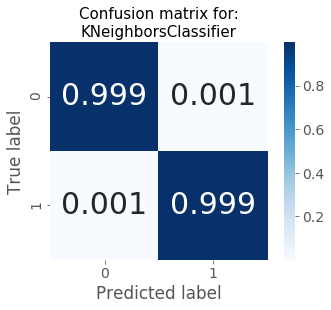

In [113]:
cm = confusion_matrix(y_train, KNN_best_model.predict(X_train_preprocessed))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
# normalize the data
# view with a heatmap
plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30},
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(KNN_best_model.__class__.__name__));

### Optimizing XGBoost (Precision) via Grid Search

In [116]:
XGB_pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('XGB', XGBClassifier(random_state=RSEED,  n_jobs=-1))
    ])
XGB_param_grid = {
    'XGB__n_estimators':[50, 100, 150, 200, 250, 300],                
    'XGB__learning_rate':[0.1, 0.5, 1.]}  

In [117]:
XGB_grid = GridSearchCV(XGB_pipe, param_grid=XGB_param_grid, cv=5, scoring='precision', 
                           verbose=5, n_jobs=-1)
XGB_grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed: 31.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer_num',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                

In [118]:
# Show best parameters
print('Best score:\n{:.2f}'.format(XGB_grid.best_score_))
print("Best parameters:\n{}".format(XGB_grid.best_params_))

Best score:
0.72
Best parameters:
{'XGB__learning_rate': 1.0, 'XGB__n_estimators': 300}


In [119]:
# Save best model as best_model
XGB_best_model = XGB_grid.best_estimator_['XGB']

In [120]:
preprocessor.fit(X_train)
X_train_preprocessed = preprocessor.transform(X_train)
y_train_predicted = XGB_best_model.predict(X_train_preprocessed)
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted)))

Accuracy: 0.74
Recall: 0.73
Precision: 0.74


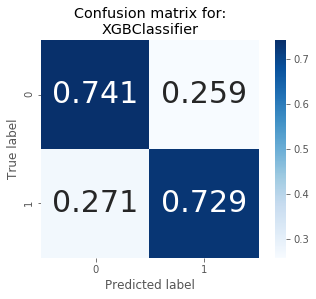

In [121]:
cm = confusion_matrix(y_train, XGB_best_model.predict(X_train_preprocessed))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
# normalize the data
# view with a heatmap
plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30},
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(XGB_best_model.__class__.__name__));

### Optimizing Random Forest (Precision) via Grid Search

In [125]:
forest_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('forest', RandomForestClassifier(random_state=RSEED, n_jobs=-1))
    ])
forest_param_grid = {
    'forest__min_samples_split': [3, 5, 10],
    'forest__n_estimators' : [100, 300, 500],
    'forest__max_depth': [1, 3, 5, 10],
    'forest__max_features': [3, 5, 7, 10, 20]}

In [126]:
forest_grid = GridSearchCV(forest_pipe, param_grid=forest_param_grid, cv=3, scoring='precision', 
                           verbose=10, n_jobs=-1)
forest_grid.fit(X_train, y_train)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 15.3min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 17

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer_num',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                

In [128]:
# Show best parameters
print('Best score:\n{:.2f}'.format(forest_grid.best_score_))
print("Best parameters:\n{}".format(forest_grid.best_params_))

Best score:
0.73
Best parameters:
{'forest__max_depth': 10, 'forest__max_features': 20, 'forest__min_samples_split': 3, 'forest__n_estimators': 500}


In [129]:
# Save best model as best_model
forest_best_model = forest_grid.best_estimator_['forest']

preprocessor.fit(X_train)
X_train_preprocessed = preprocessor.transform(X_train)

y_train_predicted_forest = forest_best_model.predict(X_train_preprocessed)
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted_forest)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted_forest)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted_forest)))

Accuracy: 0.74
Recall: 0.71
Precision: 0.75


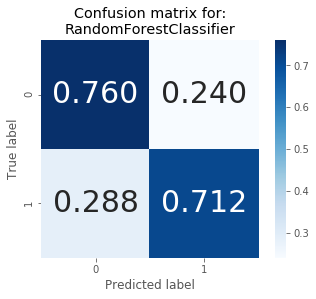

In [130]:
cm = confusion_matrix(y_train, forest_best_model.predict(X_train_preprocessed))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
# normalize the data
# view with a heatmap
plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30},
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(forest_best_model.__class__.__name__));

### Final evaluation 

In [114]:
# Preparing the test set 
preprocessor.fit(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

#### KNN 

In [115]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
knn_y_test_predicted = KNN_best_model.predict(X_test_preprocessed)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, knn_y_test_predicted)))
print("Recall: {:.2f}".format(recall_score(y_test, knn_y_test_predicted)))
print("Precision: {:.2f}".format(precision_score(y_test, knn_y_test_predicted)))
print(classification_report(y_test, knn_y_test_predicted))

Accuracy: 0.75
Recall: 0.65
Precision: 0.58
              precision    recall  f1-score   support

           0       0.84      0.79      0.82     24446
           1       0.58      0.65      0.61     10563

    accuracy                           0.75     35009
   macro avg       0.71      0.72      0.71     35009
weighted avg       0.76      0.75      0.75     35009



In [118]:
roc_auc_score(y_test, knn_y_test_predicted)

0.72266427924275

In [121]:
cm = confusion_matrix(y_test, KNN_best_model.predict(X_test_preprocessed))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
# normalize the data
# view with a heatmap
plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30},
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(KNN_best_model.__class__.__name__));

TypeError: 'numpy.ndarray' object is not callable

#### XGBoost 

In [169]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
y_test_predicted = XGB_best_model.predict(X_test_preprocessed)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted)))
print(classification_report(y_test, y_test_predicted))

Accuracy: 0.71
Recall: 0.68
Precision: 0.52
              precision    recall  f1-score   support

           0       0.84      0.73      0.78     24446
           1       0.52      0.68      0.59     10563

    accuracy                           0.71     35009
   macro avg       0.68      0.70      0.68     35009
weighted avg       0.74      0.71      0.72     35009



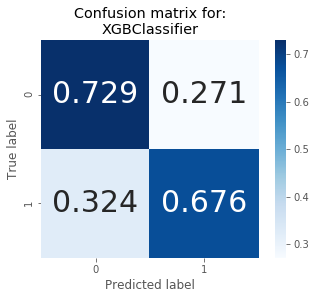

In [124]:
cm = confusion_matrix(y_test, XGB_best_model.predict(X_test_preprocessed))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
# normalize the data
# view with a heatmap
plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30},
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(XGB_best_model.__class__.__name__));

The XGBoost Model already fulfills the demands we have of our model relatively well. Our goal is to keep the second type of error as small as possible. Our model should predict as little as possible true loyal customers as unfaithful customers and at the same time our model should predict customers churn as much as possible. The XGBoost model keeps the second type of error small with 8.1% and still catches almost 40.6% of customers who want to cancel their subscription.

#### Random Forest 

In [174]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
forest_y_test_predicted = forest_best_model.predict(X_test_preprocessed)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, forest_y_test_predicted)))
print("Recall: {:.2f}".format(recall_score(y_test, forest_y_test_predicted)))
print("Precision: {:.2f}".format(precision_score(y_test, forest_y_test_predicted)))
print(classification_report(y_test, forest_y_test_predicted))

Accuracy: 0.72
Recall: 0.65
Precision: 0.52
              precision    recall  f1-score   support

           0       0.83      0.74      0.79     24446
           1       0.52      0.65      0.58     10563

    accuracy                           0.72     35009
   macro avg       0.68      0.70      0.68     35009
weighted avg       0.74      0.72      0.72     35009



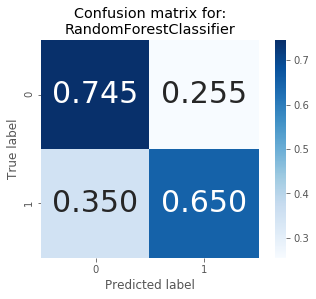

In [132]:
cm = confusion_matrix(y_test, forest_best_model.predict(X_test_preprocessed))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
# normalize the data
# view with a heatmap
plt.figure(i)
sns.heatmap(cm, annot=True, annot_kws={"size":30},
            cmap='Blues', square=True, fmt='.3f')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix for:\n{}'.format(forest_best_model.__class__.__name__));

The Random Forest Model is not really suitable. At 0.8% the second type of error is even smaller than with the XGBoost model, but the model hardly predicts customers who want to cancel their subscription with 5.9%.

#### SVM

#### Stacking 

In [142]:
# Preparing the test set 
preprocessor.fit(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [143]:
clf.fit(X_train, y_train)

StackingClassifier(cv=None,
                   estimators=[('rf_1',
                                RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                   

In [144]:
# Calculating the accuracy, recall and precision for the test set with the optimized model
stacking_y_test_predicted = clf.predict(X_test)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, stacking_y_test_predicted)))
print("Recall: {:.2f}".format(recall_score(y_test, stacking_y_test_predicted)))
print("Precision: {:.2f}".format(precision_score(y_test, stacking_y_test_predicted)))
print(classification_report(y_test, stacking_y_test_predicted))

Accuracy: 0.80
Recall: 0.46
Precision: 0.81
              precision    recall  f1-score   support

           0       0.80      0.95      0.87     24446
           1       0.81      0.46      0.58     10563

    accuracy                           0.80     35009
   macro avg       0.80      0.71      0.73     35009
weighted avg       0.80      0.80      0.78     35009



In [145]:
roc_auc_score(y_test, stacking_y_test_predicted)

0.7055639906388234

In [146]:
cmx = confusion_matrix(y_test, stacking_y_test_predicted)
cmx

TypeError: 'numpy.ndarray' object is not callable

## Future Work

We want to create a model that keeps the second type of error small and predicts even more customers who want to churn. 

Extend the newsletter data, because it contains a lot of information.

Create features with more information for the machine learning models.